<img src="https://www.th-koeln.de/img/logo.svg" style="float: right;" width="200">

# 11th exercise: <font color="#C70039">Learning and using word embeddings</font>
* Course: DIS21a.1
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook modifications and adaptations: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Student: Maximilian Pekarski
* Matriculation number: 11120099
* Date:   18.01.2023

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs12115-019-00362-9/MediaObjects/12115_2019_362_Fig2_HTML.png?as=webp" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information about your tasks (e.g. regarding the set of certain paramaters or specific computational tricks, etc.), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation (for instance, after you have run through your test plan) you may use German language.
This applies to all exercises in DIS 21a.1.  

---------------------

### <font color="ce33ff">DESCRIPTION</font>:

This notebook allows for learning how to create and use word embeddings as another popular and powerful way for associating a word with a vector. While the vectors obtained through one-hot encoding are binary and sparse, which means mostly made of zeros as well as high-dimensional, which means show the same dimensionality as the number of words in the vocabulary, "word embeddings" are low-dimensional floating point vectors. In other words these are dense vectors, in contrast to sparse vectors. 
Unlike word vectors created by one-hot encoding, word embeddings are `learned` from data. It is common to see word embeddings that are 256-dimensional, 512-dimensional or 1024-dimensional when dealing with very large vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 20.000-dimensional or higher (capturing a vocabulary of 20.000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

There are two ways to get word embeddings:

1. Learn word embeddings jointly with the main task, for example document classification or sentiment prediction as already done in the previous exercises. 
    * start with random word vectors, then learn word vectors in the same way the weights of a neural network are learned.
2. Load into the model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
    * these are called "pre-trained word embeddings"

Each of them is taught in a separate PART of this notebook.

So let's go for it.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
Within this notebook, the tasks that you need to work on are always listed as bullet points below. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook before submitting it.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully. 
    * add comments whereever you feel it necessary for better understanding.
    * run the notebook and try to follow and understand all steps and examples.
4. in PART II, try to randomly pick different (n=200) training samples and try to find a model. Compare its performance.
    * develop a testplan as you have done before, so you do not change parameters arbitrarily and use a table for the validation results. 
5. in PART II, increase the number of training samples for the task-specific embedding and compare it again with the pre-trained embedding. Does it become better? When does it beat the pre-trained embedding?
    * develop a testplan as you have done before, so you do not change parameters arbitrarily and use a table for the validation results
    
-----------------------------------------------------------------------------------

## <font color="#C70039">PART I</font>
### Learning word embeddings with the `Embedding` layer

The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the resulting embedding space would have no structure and that the words "accurate" and "exact" may end up with completely different embeddings even though they are interchangeable in many sentences. It would be very difficult for a deep neural network to make sense of such a noisy, unstructured embedding space. 

This is why within a good embedding space a geometric relationships between word vectors should reflect the semantic relationships between these words. Hence it would to be expected that the geometric distance (e.g. L2 distance) between any two word vectors do relate to the semantic distance of the associated words. I.e., words meaning very different things would be embedded to points far away from each other, while related words would be closer.

However, pragmatically seen, what makes a good word embedding space depends heavily on the task at hand. Thus the perfect word embedding space for an English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language legal document classification model, because the importance of certain semantic relationships varies from task to task. It is thus reasonable to learn a new embedding space with every new task. 

Thanks to backpropagation this learning is really easy and thanks to Keras it becomes even easier. 
Finally it is just about learning the weights of a layer, the so-called `Embedding` layer and this is what PART I is all about.

### START OF THE NOTEBOOK CODE
----------------------------------------------------------------------------------------------------------------------

In [1]:
import tensorflow
tensorflow.keras.__version__

'2.9.0'

In [2]:
from tensorflow.keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input those integers, it looks them up in an internal dictionary and finally, it returns the associated vectors. Hence, it is effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths, so e.g. one could feed into the embedding layer above batches that could have shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). Note that all sequences in a batch must have the same length since they need to be packed into a single tensor and so, sequences  shorter than others should be padded (filled-in) with zeros and sequences that are longer should be truncated (cut).

The layer above returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by a recurrent (RNN) or a convolution layer (CNN). For the RNN case see next exercise.

When instantiating an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just as always like with any other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, the trained embedding space will show a lot of structure - a kind of structure specialized for the specific problem at hand.

-----------

Now, let us apply this idea to the IMDB movie review sentiment prediction task from the earlier exercise.
Quickly prepare the data. The movie reviews will be restricted to the top 10.000 most common words (like the first time when working with this data set), and then the reviews are cut off after only 20 words. <br>
The network will simply learn 8-dimensional embeddings for each of the 10.000 words, then turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D and train a single `Dense` layer on top for classification.

In [5]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns the lists of integers into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
# Specify the maximum input length to the Embedding layer
# Later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, the activations have shape `(samples, maxlen, 8)`.

# Flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# Add the classifier on top with a single Dense layer
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# use the history object again
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 920us/step - loss: 0.6715 - acc: 0.6147 - val_loss: 0.6282 - val_acc: 0.6928
Epoch 2/10
625/625 [==============================] - 1s 808us/step - loss: 0.5530 - acc: 0.7495 - val_loss: 0.5354 - val_acc: 0.7244
Epoch 3/10
625/625 [============================

The validation accuracy is about 72-76%, which is pretty good considering that only the first 20 words in every review were taken into account. 

But note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and structured sentences (for example it would treat both _"this movie is shit"_ and _"this movie is the shit"_ as being negative "reviews" which is obviously not true). 

It would be much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole. However, that's the content of the next exercise.

----------------------------------------------------

## <font color="#C70039">PART II</font>
### Using `pre-trained` word embeddings

Instead of learning word embeddings jointly with the problem, embedding vectors can be loaded from a pre-computed embedding space known to be highly structured and to exhibit useful properties that captures generic aspects of language structure. 

The reseaon behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained CNNs in image classification. There is simply not enough data available to learn truly powerful features on its own but it is expected that the features needed are fairly generic, i.e. common visual features or semantic features. In this case it makes sense to re-use features learned on a different problem.

Such word embeddings are generally computed using word occurrence statistics which are observations about what words co-occur in sentences or documents, using a variety of techniques, some involving neural networks, others not. 
The idea of a dense, low-dimensional embedding space for words computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec algorithm, developed by Mikolov at Google in 2013.<br>

There are various pre-computed databases of word embeddings that can be downloaded and started with using a Keras `Embedding` layer. "Word2Vec" is one of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. 
It stands for "Global Vectors for Word Representation" and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from common crawl data.

Let us take a look at how GloVe embeddings in a Keras model can be used. The same method will of course be valid for Word2Vec embeddings or any other word embedding database. 

### START OF THE NOTEBOOK CODE
----------------------------------------------------------------------------------------------------------------------

## Putting it all together: from raw text to word embeddings

Use a model similar to the one that was just used earlier -- embedding sentences in sequences of vectors, flattening them and training a `Dense` layer on top. But now, this will be done using pre-trained word embeddings and instead of using the pre-tokenized IMDB data packaged in Keras it will be started from scratch by downloading the original text data.

### Download the IMDB data as raw text

First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB data set. Anyways, this data set is distributed and available all over the web and can be found anywhere. After downloading, uncompress it.

Now, using some lines of code, collect the individual training reviews into a list of strings, one string per review, and also collect the review labels (positive / negative) into a `labels` list. Make sure you are uploading the data to your Google Drive if you are using Google Colab.

In [2]:
import os

imdb_dir = '../data/acl_IMDB'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenization

Vectorize the texts and prepare a training and validation split. Use the same concepts that were introduced earlier in the notebook of exercise #10.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available, add the following restriction (otherwise, task-specific embeddings are always outperforming them): 

* restrict the training data to its first 200 samples only. Hence, try to let the model learn to classify movie reviews after looking at just 200 examples. That is almost nothing and we will see how far we can get with this. 

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random


maxlen = 100  # cut reviews after 100 words
training_samples = 200  # training on 200 samples only
validation_samples = 10000  # validation on 10000 samples
max_words = 10000  # consider the top 10000 words in the data set
random_start = random.randint(0,24999-training_samples)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since the data samples are 
# ordered (all negative first, then all positive)
''' NOTE: Better always shuffle if you are not sure data is ordered'''
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[random_start:random_start+training_samples]
y_train = labels[random_start:random_start+training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Downloading the GloVe word embeddings

Please visit `https://nlp.stanford.edu/projects/glove/` and download the pre-computed embeddings from 2014 English Wikipedia. 
By the way, this site is an excellent ressource for further reading where you can learn more about the GloVe algorithm. 
The pre-computed embeddings are packed together in a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 400.000 words. Unzip it and put it into the local disk data folder. Since its size is too large for Moodle, I recommend to download it yourself. If you are working on Google Colab please upload the necessary file "glove.6B.100d.txt" into your Google drive rather than the entire zip file content.

### Preprocessing the embeddings

Parse the unzipped file to build an index, mapping words (as strings) to their vector representation (as number vectors).

In [7]:
glove_dir = '../data/GloVE'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


Now, build an embedding matrix that can be loaded into an `Embedding` layer. It must be a matrix of shape `(max_words,embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index (built during tokenization). Note that the index `0` is not supposed to stand for any word or token. It is simply a placeholder.

In [8]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in the embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

### Model definition

Use the same model architecture as before, using a Dense layer.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                320032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Loading the GloVe embeddings in the model

The `Embedding` layer has got a single weight matrix. It is a 2D float matrix where each entry `i` is the word vector meant to be associated with index `i`. Simple enough! Load the GloVe matrix into the `Embedding` layer, which is the first layer in the model.

In [10]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, freeze the embedding layer by setting its `trainable` attribute to `False`, following the same idea that we are already familiar with in the context of pre.trained CNN features in the earlier exercise. The idea was that when parts of a model are pre-trained like this `Embedding` layer and parts are randomly initialized like this classifier, then the pre-trained parts should not be updated during training to avoid forgetting what they already know. 
The large gradient update triggered by the randomly initialized layers would be very disruptive to the already learned features.

### Training and evaluating

Compile the model and then train and validate it in one pass.

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('Ex.11.pretrained_GloVe_model.h5')

Epoch 1/10
7/7 [==============================] - 7s 1s/step - loss: 1.5992 - acc: 0.6150 - val_loss: 1.9121 - val_acc: 0.5036
Epoch 2/10
7/7 [==============================] - 1s 224ms/step - loss: 0.5052 - acc: 0.8150 - val_loss: 0.7318 - val_acc: 0.5686
Epoch 3/10
7/7 [==============================] - 0s 61ms/step - loss: 0.1316 - acc: 0.9900 - val_loss: 1.3417 - val_acc: 0.5089
Epoch 4/10
7/7 [==============================] - 0s 59ms/step - loss: 0.2722 - acc: 0.8650 - val_loss: 2.4726 - val_acc: 0.4973
Epoch 5/10
7/7 [==============================] - 1s 160ms/step - loss: 0.1012 - acc: 0.9650 - val_loss: 0.9646 - val_acc: 0.5518
Epoch 6/10
7/7 [==============================] - 0s 60ms/step - loss: 0.0243 - acc: 1.0000 - val_loss: 0.8477 - val_acc: 0.5672
Epoch 7/10
7/7 [==============================] - 0s 69ms/step - loss: 0.0134 - acc: 1.0000 - val_loss: 1.2129 - val_acc: 0.5283
Epoch 8/10
7/7 [==============================] - 2s 271ms/step - loss: 0.0138 - acc: 1.0000 - va

Plot its performance

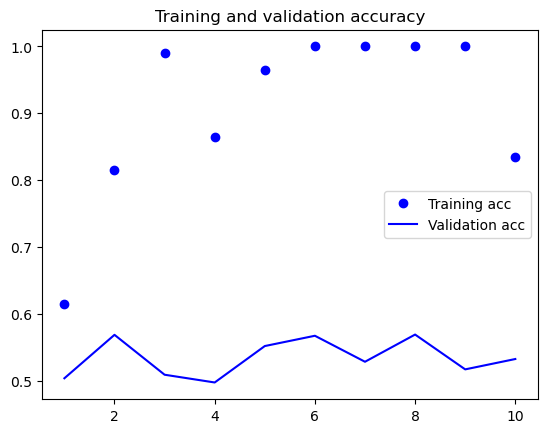

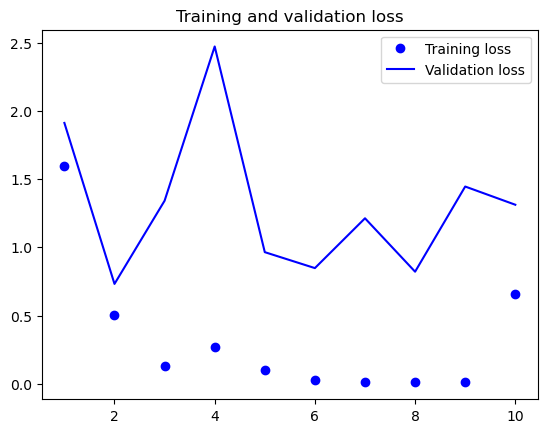

In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True '
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting which is not surprising due to the small number of training samples. Validation accuracy has high variance for the same reason but seems to reach high 50s.

Note that the precision may vary since there are so few training samples, that performance heavily depends on which exact 200 samples were picked and in this example they were picked at random (see your task list). 

----------------
### Another attempt
We can also try to train the same model <u>without</u> loading the pre-trained word embeddings and <u>without</u> freezing the embedding layer. In that case, it will result in learning a task-specific embedding of the input tokens which is generally more powerful than pre-trained word embeddings when lots of data is available. However, in this case here, there are only 200 training samples available. So let's go for it.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

#-----------------------------------------------------------------
maxlen = 100  # cut reviews after 100 words
training_samples = 200  # training on 200 samples only
validation_samples = 10000  # validation on 10000 samples
max_words = 10000  # consider the top 10,000 words in the data set
# Number of words to consider as features
embedding_dim=100
#-----------------------------------------------------------------

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                320032    
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 345ms/step - loss: 0.6932 - acc: 0.5150 - val_loss: 0.6940 - val_acc: 0.4972
Epoch 2/10
7/7 [==============================

Plot the results again.

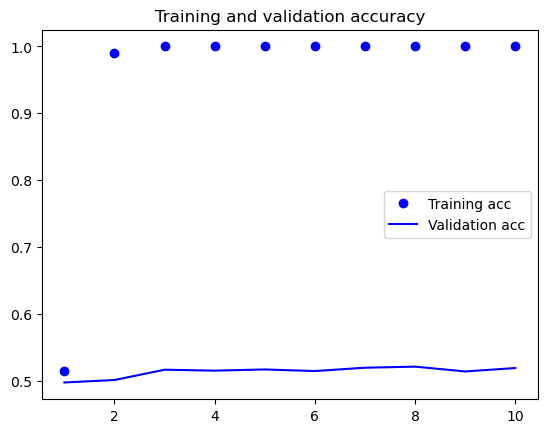

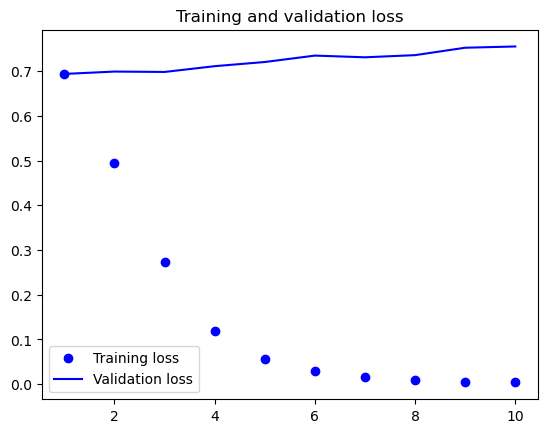

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Validation accuracy is somewhere in the low 50s. So in this case, pre-trained word embeddings do outperform jointly learned embeddings. 

Finally, evaluate the model on the test data. Do not forget to tokenize the test data.

In [16]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Last but not least, load and evaluate the pre-trained model in the testing data.

In [17]:
model.load_weights('Ex.11.pretrained_GloVe_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 5s 7ms/step - loss: 1.3109 - acc: 0.5282


[1.310872197151184, 0.5281599760055542]

This is an appalling test accuracy of 54-55%. Working with just a handful of training samples is hard and obviously crazy :-)  Take this is a warning within a lesson-learned!!!

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

In [24]:
from tensorflow.keras import optimizers

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

wandb.login()

True

In [24]:
def build_model(max_words = 10000, embedding_dim = 100, maxlen = 100):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [25]:
def train(model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, batch_size=32, epochs=10):  
    
    model.compile(loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(learning_rate=1e-4),
        metrics=['acc'])

    # callback setup
    wandb_callbacks = [
        WandbMetricsLogger(log_freq=10), 
        WandbModelCheckpoint(filepath='ex11_pretrained_{epoch:02d}')]

    model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(x_val, y_val), 
              callbacks=wandb_callbacks)

In [26]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'val_acc'},
    'parameters': 
    {
        'batch_size': {'values': [8, 16, 32, 64]},
        'epochs': {'values': [5, 10, 15, 30, 50]},
     }
}

In [34]:
def sweep_train(config_defaults=None):
    with wandb.init(config=config_defaults):
        wandb.config.architecture_name = 'ex11_pretrained'
        wandb.config.dataset_name = 'imdb'

        model = build_model()

        train(model, 
            batch_size=wandb.config.batch_size,
            epochs=wandb.config.epochs
            )

In [29]:
sweep_id = wandb.sweep(sweep_configuration, project='dis21_ex11')

Create sweep with ID: ukgc25ss
Sweep URL: https://wandb.ai/datenkrakewastaken/dis21_ex11/sweeps/ukgc25ss


In [35]:
wandb.agent(sweep_id, function=sweep_train, count=10)

wandb: Agent Starting Run: fx32p1uo with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 0.6945 - acc: 0.4900INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.1s


7/7 [==============================] - 5s 802ms/step - loss: 0.6945 - acc: 0.4900 - val_loss: 0.6930 - val_acc: 0.5060
Epoch 2/10
3/7 [===========>..................] - ETA: 0s - loss: 0.6713 - acc: 0.8646INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.1s


7/7 [==============================] - 10s 2s/step - loss: 0.6695 - acc: 0.8750 - val_loss: 0.6929 - val_acc: 0.5072
Epoch 3/10
1/7 [===>..........................] - ETA: 0s - loss: 0.6618 - acc: 0.9062INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.0s


7/7 [==============================] - 16s 3s/step - loss: 0.6552 - acc: 0.9550 - val_loss: 0.6928 - val_acc: 0.5114
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 0.6426 - acc: 0.9700INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.0s


7/7 [==============================] - 23s 4s/step - loss: 0.6426 - acc: 0.9700 - val_loss: 0.6928 - val_acc: 0.5105
Epoch 5/10
1/7 [===>..........................] - ETA: 0s - loss: 0.6350 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.0s


7/7 [==============================] - 7s 1s/step - loss: 0.6305 - acc: 0.9700 - val_loss: 0.6927 - val_acc: 0.5112
Epoch 6/10
6/7 [========================>.....] - ETA: 0s - loss: 0.6191 - acc: 0.9792INFO:tensorflow:Assets written to: ex11_pretrained_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_06)... Done. 0.0s


7/7 [==============================] - 11s 2s/step - loss: 0.6191 - acc: 0.9800 - val_loss: 0.6926 - val_acc: 0.5120
Epoch 7/10
7/7 [==============================] - ETA: 0s - loss: 0.6074 - acc: 0.9850INFO:tensorflow:Assets written to: ex11_pretrained_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_07)... Done. 0.1s


7/7 [==============================] - 6s 1s/step - loss: 0.6074 - acc: 0.9850 - val_loss: 0.6926 - val_acc: 0.5134
Epoch 8/10
7/7 [==============================] - ETA: 0s - loss: 0.5952 - acc: 0.9800INFO:tensorflow:Assets written to: ex11_pretrained_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_08)... Done. 0.0s


7/7 [==============================] - 12s 2s/step - loss: 0.5952 - acc: 0.9800 - val_loss: 0.6926 - val_acc: 0.5121
Epoch 9/10
6/7 [========================>.....] - ETA: 0s - loss: 0.5817 - acc: 0.9948INFO:tensorflow:Assets written to: ex11_pretrained_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_09)... Done. 0.1s


7/7 [==============================] - 4s 669ms/step - loss: 0.5824 - acc: 0.9900 - val_loss: 0.6927 - val_acc: 0.5107
Epoch 10/10
7/7 [==============================] - ETA: 0s - loss: 0.5694 - acc: 0.9900INFO:tensorflow:Assets written to: ex11_pretrained_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_10)... Done. 0.1s


7/7 [==============================] - 8s 1s/step - loss: 0.5694 - acc: 0.9900 - val_loss: 0.6926 - val_acc: 0.5132


batch/acc,▁▅▆▇▇▇▇███
batch/batch_step,▁▂▃▃▄▅▆▆▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▅▅▅▄▃▂▁
epoch/acc,▁▆████████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▂▂▁
epoch/val_acc,▁▂▆▅▆▇█▇▅█
epoch/val_loss,█▇▄▄▄▂▁▂▃▁
batch/acc,1.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6fcr8eq9 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10
10/13 [======================>.......] - ETA: 0s - loss: 0.6933 - acc: 0.4812INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.1s


13/13 [==============================] - 12s 954ms/step - loss: 0.6930 - acc: 0.5100 - val_loss: 0.6930 - val_acc: 0.5113
Epoch 2/10
10/13 [======================>.......] - ETA: 0s - loss: 0.6683 - acc: 0.9625INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.1s


13/13 [==============================] - 11s 955ms/step - loss: 0.6679 - acc: 0.9550 - val_loss: 0.6929 - val_acc: 0.5113
Epoch 3/10
 8/13 [=================>............] - ETA: 0s - loss: 0.6524 - acc: 0.9922INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.0s


13/13 [==============================] - 15s 1s/step - loss: 0.6511 - acc: 0.9800 - val_loss: 0.6928 - val_acc: 0.5117
Epoch 4/10
11/13 [========================>.....] - ETA: 0s - loss: 0.6347 - acc: 0.9886INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.1s


13/13 [==============================] - 14s 1s/step - loss: 0.6347 - acc: 0.9900 - val_loss: 0.6927 - val_acc: 0.5117
Epoch 5/10
13/13 [==============================] - ETA: 0s - loss: 0.6179 - acc: 0.9800INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.0s


13/13 [==============================] - 4s 356ms/step - loss: 0.6179 - acc: 0.9800 - val_loss: 0.6927 - val_acc: 0.5114
Epoch 6/10
 9/13 [===================>..........] - ETA: 0s - loss: 0.5998 - acc: 0.9931INFO:tensorflow:Assets written to: ex11_pretrained_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_06)... Done. 0.0s


13/13 [==============================] - 3s 275ms/step - loss: 0.6004 - acc: 0.9900 - val_loss: 0.6927 - val_acc: 0.5120
Epoch 7/10
13/13 [==============================] - ETA: 0s - loss: 0.5820 - acc: 0.9900INFO:tensorflow:Assets written to: ex11_pretrained_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_07)... Done. 0.1s


13/13 [==============================] - 23s 2s/step - loss: 0.5820 - acc: 0.9900 - val_loss: 0.6927 - val_acc: 0.5128
Epoch 8/10
13/13 [==============================] - ETA: 0s - loss: 0.5626 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_08)... Done. 0.1s


13/13 [==============================] - 18s 1s/step - loss: 0.5626 - acc: 1.0000 - val_loss: 0.6927 - val_acc: 0.5124
Epoch 9/10
12/13 [==========================>...] - ETA: 0s - loss: 0.5420 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_09)... Done. 0.0s


13/13 [==============================] - 13s 1s/step - loss: 0.5417 - acc: 1.0000 - val_loss: 0.6927 - val_acc: 0.5117
Epoch 10/10
10/13 [======================>.......] - ETA: 0s - loss: 0.5197 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_10)... Done. 0.1s


13/13 [==============================] - 23s 2s/step - loss: 0.5192 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.5116


batch/acc,▁▄▇█████████████████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
epoch/acc,▁▇████████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▄▄▃▂▁
epoch/val_acc,▁▁▃▃▂▄█▆▃▂
epoch/val_loss,█▇▅▃▃▂▂▁▃▃
batch/acc,1.0


wandb: Agent Starting Run: e1t2jxuc with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6943 - acc: 0.5000INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.1s


4/4 [==============================] - 2s 599ms/step - loss: 0.6946 - acc: 0.4750 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 2/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6726 - acc: 0.9062INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.1s


4/4 [==============================] - 2s 537ms/step - loss: 0.6726 - acc: 0.8750 - val_loss: 0.6932 - val_acc: 0.5023
Epoch 3/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6617 - acc: 0.9531INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.1s


4/4 [==============================] - 1s 475ms/step - loss: 0.6613 - acc: 0.9450 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 4/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6520 - acc: 0.9219INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.0s


4/4 [==============================] - 1s 443ms/step - loss: 0.6515 - acc: 0.9650 - val_loss: 0.6931 - val_acc: 0.5045
Epoch 5/30
4/4 [==============================] - ETA: 0s - loss: 0.6431 - acc: 0.9850INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.0s


4/4 [==============================] - 2s 510ms/step - loss: 0.6431 - acc: 0.9850 - val_loss: 0.6930 - val_acc: 0.5053
Epoch 6/30
4/4 [==============================] - ETA: 0s - loss: 0.6351 - acc: 0.9900INFO:tensorflow:Assets written to: ex11_pretrained_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_06)... Done. 0.1s


4/4 [==============================] - 2s 793ms/step - loss: 0.6351 - acc: 0.9900 - val_loss: 0.6930 - val_acc: 0.5068
Epoch 7/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6317 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_07)... Done. 0.0s


4/4 [==============================] - 1s 452ms/step - loss: 0.6276 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5062
Epoch 8/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6229 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_08)... Done. 0.1s


4/4 [==============================] - 2s 552ms/step - loss: 0.6199 - acc: 0.9800 - val_loss: 0.6929 - val_acc: 0.5083
Epoch 9/30
4/4 [==============================] - ETA: 0s - loss: 0.6126 - acc: 0.9900INFO:tensorflow:Assets written to: ex11_pretrained_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_09)... Done. 0.1s


4/4 [==============================] - 2s 550ms/step - loss: 0.6126 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5075
Epoch 10/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6013 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_10)... Done. 0.0s


4/4 [==============================] - 2s 498ms/step - loss: 0.6052 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5085
Epoch 11/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6031 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_11)... Done. 0.1s


4/4 [==============================] - 2s 532ms/step - loss: 0.5977 - acc: 0.9900 - val_loss: 0.6928 - val_acc: 0.5086
Epoch 12/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5915 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_12)... Done. 0.1s


4/4 [==============================] - 2s 532ms/step - loss: 0.5899 - acc: 0.9900 - val_loss: 0.6928 - val_acc: 0.5081
Epoch 13/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5894 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_13)... Done. 0.1s


4/4 [==============================] - 2s 521ms/step - loss: 0.5821 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5071
Epoch 14/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5727 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_14)... Done. 0.1s


4/4 [==============================] - 1s 457ms/step - loss: 0.5744 - acc: 0.9900 - val_loss: 0.6928 - val_acc: 0.5082
Epoch 15/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5631 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_15)... Done. 0.0s


4/4 [==============================] - 2s 502ms/step - loss: 0.5660 - acc: 0.9900 - val_loss: 0.6928 - val_acc: 0.5089
Epoch 16/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5662 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_16\assets


wandb: Adding directory to artifact (.\ex11_pretrained_16)... Done. 0.0s


4/4 [==============================] - 1s 492ms/step - loss: 0.5573 - acc: 0.9900 - val_loss: 0.6928 - val_acc: 0.5093
Epoch 17/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5484 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_17\assets


wandb: Adding directory to artifact (.\ex11_pretrained_17)... Done. 0.1s


4/4 [==============================] - 2s 518ms/step - loss: 0.5488 - acc: 0.9900 - val_loss: 0.6928 - val_acc: 0.5098
Epoch 18/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5378 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_18\assets


wandb: Adding directory to artifact (.\ex11_pretrained_18)... Done. 0.1s


4/4 [==============================] - 2s 530ms/step - loss: 0.5399 - acc: 0.9900 - val_loss: 0.6928 - val_acc: 0.5102
Epoch 19/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5324 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_19\assets


wandb: Adding directory to artifact (.\ex11_pretrained_19)... Done. 0.1s


4/4 [==============================] - 2s 558ms/step - loss: 0.5308 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5084
Epoch 20/30
4/4 [==============================] - ETA: 0s - loss: 0.5213 - acc: 0.9900INFO:tensorflow:Assets written to: ex11_pretrained_20\assets


wandb: Adding directory to artifact (.\ex11_pretrained_20)... Done. 0.1s


4/4 [==============================] - 3s 1s/step - loss: 0.5213 - acc: 0.9900 - val_loss: 0.6928 - val_acc: 0.5101
Epoch 21/30
4/4 [==============================] - ETA: 0s - loss: 0.5117 - acc: 0.9950INFO:tensorflow:Assets written to: ex11_pretrained_21\assets


wandb: Adding directory to artifact (.\ex11_pretrained_21)... Done. 0.0s


4/4 [==============================] - 4s 1s/step - loss: 0.5117 - acc: 0.9950 - val_loss: 0.6929 - val_acc: 0.5090
Epoch 22/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5108 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_22\assets


wandb: Adding directory to artifact (.\ex11_pretrained_22)... Done. 0.1s


4/4 [==============================] - 2s 696ms/step - loss: 0.5019 - acc: 0.9900 - val_loss: 0.6930 - val_acc: 0.5100
Epoch 23/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4972 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_23\assets


wandb: Adding directory to artifact (.\ex11_pretrained_23)... Done. 0.1s


4/4 [==============================] - 3s 1s/step - loss: 0.4916 - acc: 0.9900 - val_loss: 0.6930 - val_acc: 0.5086
Epoch 24/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4779 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_24\assets


wandb: Adding directory to artifact (.\ex11_pretrained_24)... Done. 0.1s


4/4 [==============================] - 2s 527ms/step - loss: 0.4808 - acc: 0.9900 - val_loss: 0.6930 - val_acc: 0.5089
Epoch 25/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4692 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_25\assets


wandb: Adding directory to artifact (.\ex11_pretrained_25)... Done. 0.1s


4/4 [==============================] - 2s 583ms/step - loss: 0.4702 - acc: 0.9900 - val_loss: 0.6931 - val_acc: 0.5082
Epoch 26/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4645 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_26\assets


wandb: Adding directory to artifact (.\ex11_pretrained_26)... Done. 0.0s


4/4 [==============================] - 2s 558ms/step - loss: 0.4592 - acc: 0.9900 - val_loss: 0.6932 - val_acc: 0.5096
Epoch 27/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4543 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_27\assets


wandb: Adding directory to artifact (.\ex11_pretrained_27)... Done. 0.1s


4/4 [==============================] - 2s 561ms/step - loss: 0.4482 - acc: 0.9900 - val_loss: 0.6932 - val_acc: 0.5094
Epoch 28/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4357 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_28\assets


wandb: Adding directory to artifact (.\ex11_pretrained_28)... Done. 0.1s


4/4 [==============================] - 2s 556ms/step - loss: 0.4372 - acc: 0.9900 - val_loss: 0.6934 - val_acc: 0.5094
Epoch 29/30
4/4 [==============================] - ETA: 0s - loss: 0.4258 - acc: 0.9900INFO:tensorflow:Assets written to: ex11_pretrained_29\assets


wandb: Adding directory to artifact (.\ex11_pretrained_29)... Done. 0.0s


4/4 [==============================] - 3s 1s/step - loss: 0.4258 - acc: 0.9900 - val_loss: 0.6935 - val_acc: 0.5088
Epoch 30/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4224 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_30\assets


wandb: Adding directory to artifact (.\ex11_pretrained_30)... Done. 0.0s


4/4 [==============================] - 2s 611ms/step - loss: 0.4146 - acc: 0.9950 - val_loss: 0.6934 - val_acc: 0.5097


batch/acc,▁▇▇▇██████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
epoch/acc,▁▆▇███████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
epoch/val_acc,▁▃▄▄▅▆▅▇▆▇▇▇▆▇▇▇██▇█▇█▇▇▇█▇▇▇█
epoch/val_loss,▆▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▃▃▃▃▄▅▆▇██
batch/acc,1.0


wandb: Agent Starting Run: 7aiolaka with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/30
4/7 [================>.............] - ETA: 0s - loss: 0.6935 - acc: 0.5078INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.0s


7/7 [==============================] - 8s 1s/step - loss: 0.6925 - acc: 0.5500 - val_loss: 0.6931 - val_acc: 0.5052
Epoch 2/30
5/7 [====================>.........] - ETA: 0s - loss: 0.6662 - acc: 0.9125INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.1s


7/7 [==============================] - 4s 637ms/step - loss: 0.6668 - acc: 0.9100 - val_loss: 0.6930 - val_acc: 0.5060
Epoch 3/30
4/7 [================>.............] - ETA: 0s - loss: 0.6514 - acc: 0.9766INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.0s


7/7 [==============================] - 2s 346ms/step - loss: 0.6519 - acc: 0.9700 - val_loss: 0.6930 - val_acc: 0.5056
Epoch 4/30
4/7 [================>.............] - ETA: 0s - loss: 0.6399 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.0s


7/7 [==============================] - 6s 996ms/step - loss: 0.6386 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5063
Epoch 5/30
7/7 [==============================] - ETA: 0s - loss: 0.6259 - acc: 0.9900INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.0s


7/7 [==============================] - 8s 1s/step - loss: 0.6259 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5065
Epoch 6/30
7/7 [==============================] - ETA: 0s - loss: 0.6135 - acc: 0.9850INFO:tensorflow:Assets written to: ex11_pretrained_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_06)... Done. 0.1s


7/7 [==============================] - 12s 2s/step - loss: 0.6135 - acc: 0.9850 - val_loss: 0.6929 - val_acc: 0.5063
Epoch 7/30
4/7 [================>.............] - ETA: 0s - loss: 0.6040 - acc: 0.9922INFO:tensorflow:Assets written to: ex11_pretrained_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_07)... Done. 0.1s


7/7 [==============================] - 4s 662ms/step - loss: 0.6007 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5075
Epoch 8/30
5/7 [====================>.........] - ETA: 0s - loss: 0.5874 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_08)... Done. 0.0s


7/7 [==============================] - 14s 2s/step - loss: 0.5875 - acc: 1.0000 - val_loss: 0.6927 - val_acc: 0.5098
Epoch 9/30
6/7 [========================>.....] - ETA: 0s - loss: 0.5725 - acc: 0.9896INFO:tensorflow:Assets written to: ex11_pretrained_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_09)... Done. 0.0s


7/7 [==============================] - 15s 2s/step - loss: 0.5740 - acc: 0.9850 - val_loss: 0.6928 - val_acc: 0.5125
Epoch 10/30
6/7 [========================>.....] - ETA: 0s - loss: 0.5598 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_10)... Done. 0.1s


7/7 [==============================] - 11s 2s/step - loss: 0.5601 - acc: 0.9950 - val_loss: 0.6928 - val_acc: 0.5107
Epoch 11/30
1/7 [===>..........................] - ETA: 0s - loss: 0.5377 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_11)... Done. 0.1s


7/7 [==============================] - 11s 2s/step - loss: 0.5455 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.5100
Epoch 12/30
6/7 [========================>.....] - ETA: 0s - loss: 0.5299 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_12)... Done. 0.1s


7/7 [==============================] - 15s 2s/step - loss: 0.5302 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.5108
Epoch 13/30
5/7 [====================>.........] - ETA: 0s - loss: 0.5160 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_13)... Done. 0.0s


7/7 [==============================] - 15s 3s/step - loss: 0.5143 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.5105
Epoch 14/30
4/7 [================>.............] - ETA: 0s - loss: 0.5005 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_14)... Done. 0.0s


7/7 [==============================] - 13s 2s/step - loss: 0.4978 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.5101
Epoch 15/30
6/7 [========================>.....] - ETA: 0s - loss: 0.4809 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_15)... Done. 0.0s


7/7 [==============================] - 12s 2s/step - loss: 0.4806 - acc: 1.0000 - val_loss: 0.6930 - val_acc: 0.5118
Epoch 16/30
3/7 [===========>..................] - ETA: 0s - loss: 0.4658 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_16\assets


wandb: Adding directory to artifact (.\ex11_pretrained_16)... Done. 0.1s


7/7 [==============================] - 15s 2s/step - loss: 0.4633 - acc: 1.0000 - val_loss: 0.6930 - val_acc: 0.5120
Epoch 17/30
1/7 [===>..........................] - ETA: 0s - loss: 0.4395 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_17\assets


wandb: Adding directory to artifact (.\ex11_pretrained_17)... Done. 0.0s


7/7 [==============================] - 15s 3s/step - loss: 0.4455 - acc: 1.0000 - val_loss: 0.6931 - val_acc: 0.5139
Epoch 18/30
5/7 [====================>.........] - ETA: 0s - loss: 0.4320 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_18\assets


wandb: Adding directory to artifact (.\ex11_pretrained_18)... Done. 0.1s


7/7 [==============================] - 16s 3s/step - loss: 0.4282 - acc: 1.0000 - val_loss: 0.6932 - val_acc: 0.5134
Epoch 19/30
5/7 [====================>.........] - ETA: 0s - loss: 0.4127 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_19\assets


wandb: Adding directory to artifact (.\ex11_pretrained_19)... Done. 0.0s


7/7 [==============================] - 17s 3s/step - loss: 0.4102 - acc: 1.0000 - val_loss: 0.6936 - val_acc: 0.5131
Epoch 20/30
7/7 [==============================] - ETA: 0s - loss: 0.3921 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_20\assets


wandb: Adding directory to artifact (.\ex11_pretrained_20)... Done. 0.0s


7/7 [==============================] - 16s 3s/step - loss: 0.3921 - acc: 1.0000 - val_loss: 0.6937 - val_acc: 0.5136
Epoch 21/30
7/7 [==============================] - ETA: 0s - loss: 0.3740 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_21\assets


wandb: Adding directory to artifact (.\ex11_pretrained_21)... Done. 0.0s


7/7 [==============================] - 14s 2s/step - loss: 0.3740 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.5142
Epoch 22/30
7/7 [==============================] - ETA: 0s - loss: 0.3554 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_22\assets


wandb: Adding directory to artifact (.\ex11_pretrained_22)... Done. 0.1s


7/7 [==============================] - 20s 3s/step - loss: 0.3554 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.5156
Epoch 23/30
6/7 [========================>.....] - ETA: 0s - loss: 0.3368 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_23\assets


wandb: Adding directory to artifact (.\ex11_pretrained_23)... Done. 0.1s


7/7 [==============================] - 17s 3s/step - loss: 0.3375 - acc: 1.0000 - val_loss: 0.6944 - val_acc: 0.5131
Epoch 24/30
7/7 [==============================] - ETA: 0s - loss: 0.3198 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_24\assets


wandb: Adding directory to artifact (.\ex11_pretrained_24)... Done. 0.1s


7/7 [==============================] - 16s 3s/step - loss: 0.3198 - acc: 1.0000 - val_loss: 0.6947 - val_acc: 0.5152
Epoch 25/30
4/7 [================>.............] - ETA: 0s - loss: 0.3039 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_25\assets


wandb: Adding directory to artifact (.\ex11_pretrained_25)... Done. 0.1s


7/7 [==============================] - 12s 2s/step - loss: 0.3023 - acc: 1.0000 - val_loss: 0.6949 - val_acc: 0.5144
Epoch 26/30
3/7 [===========>..................] - ETA: 0s - loss: 0.2836 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_26\assets


wandb: Adding directory to artifact (.\ex11_pretrained_26)... Done. 0.1s


7/7 [==============================] - 18s 3s/step - loss: 0.2847 - acc: 1.0000 - val_loss: 0.6951 - val_acc: 0.5152
Epoch 27/30
4/7 [================>.............] - ETA: 0s - loss: 0.2637 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_27\assets


wandb: Adding directory to artifact (.\ex11_pretrained_27)... Done. 0.1s


7/7 [==============================] - 14s 2s/step - loss: 0.2681 - acc: 1.0000 - val_loss: 0.6956 - val_acc: 0.5153
Epoch 28/30
6/7 [========================>.....] - ETA: 0s - loss: 0.2525 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_28\assets


wandb: Adding directory to artifact (.\ex11_pretrained_28)... Done. 0.1s


7/7 [==============================] - 16s 3s/step - loss: 0.2518 - acc: 1.0000 - val_loss: 0.6960 - val_acc: 0.5152
Epoch 29/30
7/7 [==============================] - ETA: 0s - loss: 0.2358 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_29\assets


wandb: Adding directory to artifact (.\ex11_pretrained_29)... Done. 0.0s


7/7 [==============================] - 15s 3s/step - loss: 0.2358 - acc: 1.0000 - val_loss: 0.6966 - val_acc: 0.5150
Epoch 30/30
7/7 [==============================] - ETA: 0s - loss: 0.2201 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_30\assets


wandb: Adding directory to artifact (.\ex11_pretrained_30)... Done. 0.0s


7/7 [==============================] - 14s 2s/step - loss: 0.2201 - acc: 1.0000 - val_loss: 0.6971 - val_acc: 0.5150


batch/acc,▁▆████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
epoch/acc,▁▇████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
epoch/val_acc,▁▂▁▂▂▂▃▄▆▅▄▅▅▄▅▆▇▇▆▇▇█▆█▇█████
epoch/val_loss,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▆▆▇█
batch/acc,1.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: duw63io5 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 15
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6908 - acc: 0.4844INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.0s


4/4 [==============================] - 2s 472ms/step - loss: 0.6920 - acc: 0.5000 - val_loss: 0.6937 - val_acc: 0.4984
Epoch 2/15
4/4 [==============================] - ETA: 0s - loss: 0.6644 - acc: 0.7200INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.1s


4/4 [==============================] - 1s 469ms/step - loss: 0.6644 - acc: 0.7200 - val_loss: 0.6935 - val_acc: 0.5012
Epoch 3/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6507 - acc: 0.8750INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.1s


4/4 [==============================] - 3s 862ms/step - loss: 0.6497 - acc: 0.8750 - val_loss: 0.6936 - val_acc: 0.5023
Epoch 4/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6376 - acc: 0.9219INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.0s


4/4 [==============================] - 1s 455ms/step - loss: 0.6379 - acc: 0.9300 - val_loss: 0.6935 - val_acc: 0.5022
Epoch 5/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6238 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.0s


4/4 [==============================] - 2s 545ms/step - loss: 0.6274 - acc: 0.9600 - val_loss: 0.6936 - val_acc: 0.5023
Epoch 6/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6166 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_06)... Done. 0.1s


4/4 [==============================] - 1s 465ms/step - loss: 0.6176 - acc: 0.9950 - val_loss: 0.6935 - val_acc: 0.5046
Epoch 7/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6115 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_07)... Done. 0.1s


4/4 [==============================] - 2s 499ms/step - loss: 0.6082 - acc: 0.9900 - val_loss: 0.6938 - val_acc: 0.5014
Epoch 8/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5930 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_08)... Done. 0.1s


4/4 [==============================] - 1s 488ms/step - loss: 0.5988 - acc: 0.9950 - val_loss: 0.6938 - val_acc: 0.5018
Epoch 9/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5995 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_09)... Done. 0.1s


4/4 [==============================] - 1s 454ms/step - loss: 0.5896 - acc: 1.0000 - val_loss: 0.6938 - val_acc: 0.5032
Epoch 10/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5858 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_10)... Done. 0.0s


4/4 [==============================] - 1s 466ms/step - loss: 0.5804 - acc: 1.0000 - val_loss: 0.6940 - val_acc: 0.5031
Epoch 11/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5734 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_11)... Done. 0.0s


4/4 [==============================] - 2s 525ms/step - loss: 0.5710 - acc: 1.0000 - val_loss: 0.6940 - val_acc: 0.5048
Epoch 12/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5651 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_12)... Done. 1.1s


4/4 [==============================] - 2s 798ms/step - loss: 0.5614 - acc: 1.0000 - val_loss: 0.6942 - val_acc: 0.5028
Epoch 13/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5516 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_13)... Done. 0.1s


4/4 [==============================] - 1s 481ms/step - loss: 0.5518 - acc: 1.0000 - val_loss: 0.6943 - val_acc: 0.5038
Epoch 14/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5539 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_14)... Done. 0.1s


4/4 [==============================] - 1s 460ms/step - loss: 0.5414 - acc: 1.0000 - val_loss: 0.6944 - val_acc: 0.5047
Epoch 15/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5362 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_15)... Done. 0.0s


4/4 [==============================] - 2s 650ms/step - loss: 0.5309 - acc: 1.0000 - val_loss: 0.6946 - val_acc: 0.5051


batch/acc,▁▅▆▇███████████
batch/batch_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▆▅▅▄▄▄▃▃▂▂▂▁
epoch/acc,▁▄▆▇▇██████████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▄▃▃▂▂▁▁
epoch/val_acc,▁▄▅▅▅▇▄▅▆▆█▆▇██
epoch/val_loss,▂▁▁▁▂▁▃▃▃▄▄▆▆▇█
batch/acc,1.0


wandb: Agent Starting Run: 5dvglse4 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 30
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/30
20/25 [=======================>......] - ETA: 0s - loss: 0.6945 - acc: 0.5000INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.1s


25/25 [==============================] - 42s 2s/step - loss: 0.6945 - acc: 0.4950 - val_loss: 0.6930 - val_acc: 0.5050
Epoch 2/30
24/25 [===========================>..] - ETA: 0s - loss: 0.6609 - acc: 0.8802INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.0s


25/25 [==============================] - 18s 770ms/step - loss: 0.6608 - acc: 0.8800 - val_loss: 0.6930 - val_acc: 0.5061
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.6353 - acc: 0.9950INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.0s


25/25 [==============================] - 19s 791ms/step - loss: 0.6353 - acc: 0.9950 - val_loss: 0.6929 - val_acc: 0.5093
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.6096 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.0s


25/25 [==============================] - 42s 2s/step - loss: 0.6096 - acc: 1.0000 - val_loss: 0.6929 - val_acc: 0.5081
Epoch 5/30
24/25 [===========================>..] - ETA: 0s - loss: 0.5819 - acc: 0.9948INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.0s


25/25 [==============================] - 47s 2s/step - loss: 0.5821 - acc: 0.9950 - val_loss: 0.6929 - val_acc: 0.5081
Epoch 6/30
23/25 [==========================>...] - ETA: 0s - loss: 0.5537 - acc: 0.9837INFO:tensorflow:Assets written to: ex11_pretrained_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_06)... Done. 0.1s


25/25 [==============================] - 26s 1s/step - loss: 0.5522 - acc: 0.9850 - val_loss: 0.6935 - val_acc: 0.5067
Epoch 7/30
23/25 [==========================>...] - ETA: 0s - loss: 0.5229 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_07)... Done. 0.0s


25/25 [==============================] - 22s 905ms/step - loss: 0.5207 - acc: 1.0000 - val_loss: 0.6936 - val_acc: 0.5097
Epoch 8/30
25/25 [==============================] - ETA: 0s - loss: 0.4868 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_08)... Done. 0.0s


25/25 [==============================] - 25s 1s/step - loss: 0.4868 - acc: 1.0000 - val_loss: 0.6940 - val_acc: 0.5102
Epoch 9/30
20/25 [=======================>......] - ETA: 0s - loss: 0.4529 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_09)... Done. 0.1s


25/25 [==============================] - 19s 784ms/step - loss: 0.4506 - acc: 0.9950 - val_loss: 0.6950 - val_acc: 0.5092
Epoch 10/30
25/25 [==============================] - ETA: 0s - loss: 0.4135 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_10)... Done. 0.1s


25/25 [==============================] - 22s 928ms/step - loss: 0.4135 - acc: 1.0000 - val_loss: 0.6960 - val_acc: 0.5093
Epoch 11/30
16/25 [==================>...........] - ETA: 0s - loss: 0.3781 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_11)... Done. 0.1s


25/25 [==============================] - 10s 418ms/step - loss: 0.3758 - acc: 1.0000 - val_loss: 0.6964 - val_acc: 0.5104
Epoch 12/30
23/25 [==========================>...] - ETA: 0s - loss: 0.3373 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_12)... Done. 0.0s


25/25 [==============================] - 39s 2s/step - loss: 0.3380 - acc: 1.0000 - val_loss: 0.6987 - val_acc: 0.5095
Epoch 13/30
22/25 [=========================>....] - ETA: 0s - loss: 0.3014 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_13)... Done. 0.1s


25/25 [==============================] - 14s 601ms/step - loss: 0.3023 - acc: 1.0000 - val_loss: 0.6989 - val_acc: 0.5091
Epoch 14/30
25/25 [==============================] - ETA: 0s - loss: 0.2665 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_14)... Done. 0.1s


25/25 [==============================] - 25s 1s/step - loss: 0.2665 - acc: 1.0000 - val_loss: 0.7005 - val_acc: 0.5101
Epoch 15/30
25/25 [==============================] - ETA: 0s - loss: 0.2327 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_15)... Done. 0.0s


25/25 [==============================] - 19s 771ms/step - loss: 0.2327 - acc: 1.0000 - val_loss: 0.7033 - val_acc: 0.5090
Epoch 16/30
25/25 [==============================] - ETA: 0s - loss: 0.2018 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_16\assets


wandb: Adding directory to artifact (.\ex11_pretrained_16)... Done. 0.1s


25/25 [==============================] - 19s 794ms/step - loss: 0.2018 - acc: 1.0000 - val_loss: 0.7037 - val_acc: 0.5112
Epoch 17/30
23/25 [==========================>...] - ETA: 0s - loss: 0.1687 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_17\assets


wandb: Adding directory to artifact (.\ex11_pretrained_17)... Done. 0.1s


25/25 [==============================] - 59s 2s/step - loss: 0.1716 - acc: 1.0000 - val_loss: 0.7047 - val_acc: 0.5125
Epoch 18/30
25/25 [==============================] - ETA: 0s - loss: 0.1449 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_18\assets


wandb: Adding directory to artifact (.\ex11_pretrained_18)... Done. 0.1s


25/25 [==============================] - 50s 2s/step - loss: 0.1449 - acc: 1.0000 - val_loss: 0.7062 - val_acc: 0.5122
Epoch 19/30
24/25 [===========================>..] - ETA: 0s - loss: 0.1211 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_19\assets


wandb: Adding directory to artifact (.\ex11_pretrained_19)... Done. 0.0s


25/25 [==============================] - 48s 2s/step - loss: 0.1206 - acc: 1.0000 - val_loss: 0.7077 - val_acc: 0.5128
Epoch 20/30
24/25 [===========================>..] - ETA: 0s - loss: 0.0996 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_20\assets


wandb: Adding directory to artifact (.\ex11_pretrained_20)... Done. 0.1s


25/25 [==============================] - 41s 2s/step - loss: 0.0988 - acc: 1.0000 - val_loss: 0.7093 - val_acc: 0.5121
Epoch 21/30
25/25 [==============================] - ETA: 0s - loss: 0.0801 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_21\assets


wandb: Adding directory to artifact (.\ex11_pretrained_21)... Done. 0.0s


25/25 [==============================] - 43s 2s/step - loss: 0.0801 - acc: 1.0000 - val_loss: 0.7103 - val_acc: 0.5134
Epoch 22/30
24/25 [===========================>..] - ETA: 0s - loss: 0.0642 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_22\assets


wandb: Adding directory to artifact (.\ex11_pretrained_22)... Done. 0.0s


25/25 [==============================] - 40s 2s/step - loss: 0.0640 - acc: 1.0000 - val_loss: 0.7131 - val_acc: 0.5136
Epoch 23/30
24/25 [===========================>..] - ETA: 0s - loss: 0.0507 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_23\assets


wandb: Adding directory to artifact (.\ex11_pretrained_23)... Done. 0.0s


25/25 [==============================] - 40s 2s/step - loss: 0.0505 - acc: 1.0000 - val_loss: 0.7155 - val_acc: 0.5151
Epoch 24/30
25/25 [==============================] - ETA: 0s - loss: 0.0393 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_24\assets


wandb: Adding directory to artifact (.\ex11_pretrained_24)... Done. 0.1s


25/25 [==============================] - 42s 2s/step - loss: 0.0393 - acc: 1.0000 - val_loss: 0.7187 - val_acc: 0.5149
Epoch 25/30
21/25 [========================>.....] - ETA: 0s - loss: 0.0304 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_25\assets


wandb: Adding directory to artifact (.\ex11_pretrained_25)... Done. 0.1s


25/25 [==============================] - 36s 2s/step - loss: 0.0301 - acc: 1.0000 - val_loss: 0.7218 - val_acc: 0.5142
Epoch 26/30
23/25 [==========================>...] - ETA: 0s - loss: 0.0227 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_26\assets


wandb: Adding directory to artifact (.\ex11_pretrained_26)... Done. 0.1s


25/25 [==============================] - 29s 1s/step - loss: 0.0229 - acc: 1.0000 - val_loss: 0.7257 - val_acc: 0.5128
Epoch 27/30
21/25 [========================>.....] - ETA: 0s - loss: 0.0174 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_27\assets


wandb: Adding directory to artifact (.\ex11_pretrained_27)... Done. 0.1s


25/25 [==============================] - 37s 2s/step - loss: 0.0173 - acc: 1.0000 - val_loss: 0.7301 - val_acc: 0.5140
Epoch 28/30
23/25 [==========================>...] - ETA: 0s - loss: 0.0129 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_28\assets


wandb: Adding directory to artifact (.\ex11_pretrained_28)... Done. 0.1s


25/25 [==============================] - 40s 2s/step - loss: 0.0129 - acc: 1.0000 - val_loss: 0.7355 - val_acc: 0.5123
Epoch 29/30
25/25 [==============================] - ETA: 0s - loss: 0.0095 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_29\assets


wandb: Adding directory to artifact (.\ex11_pretrained_29)... Done. 0.0s


25/25 [==============================] - 22s 896ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.7423 - val_acc: 0.5126
Epoch 30/30
16/25 [==================>...........] - ETA: 0s - loss: 0.0074 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_30\assets


wandb: Adding directory to artifact (.\ex11_pretrained_30)... Done. 0.0s


25/25 [==============================] - 22s 928ms/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.7466 - val_acc: 0.5134


batch/acc,▆▁▆█████████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/acc,▁▆████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_acc,▁▂▄▃▃▂▄▅▄▄▅▄▄▅▄▅▆▆▆▆▇▇██▇▆▇▆▆▇
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▆▇▇█
batch/acc,1.0


wandb: Agent Starting Run: 7r0qdchr with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10
24/25 [===========================>..] - ETA: 0s - loss: 0.6959 - acc: 0.4531INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.0s


25/25 [==============================] - 36s 1s/step - loss: 0.6960 - acc: 0.4450 - val_loss: 0.6933 - val_acc: 0.4981
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.6645 - acc: 0.9550INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.1s


25/25 [==============================] - 39s 2s/step - loss: 0.6645 - acc: 0.9550 - val_loss: 0.6932 - val_acc: 0.5025
Epoch 3/10
24/25 [===========================>..] - ETA: 0s - loss: 0.6408 - acc: 0.9896INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.1s


25/25 [==============================] - 41s 2s/step - loss: 0.6408 - acc: 0.9900 - val_loss: 0.6931 - val_acc: 0.5042
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.6160 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.1s


25/25 [==============================] - 39s 2s/step - loss: 0.6160 - acc: 1.0000 - val_loss: 0.6929 - val_acc: 0.5090
Epoch 5/10
19/25 [=====================>........] - ETA: 0s - loss: 0.5896 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.0s


25/25 [==============================] - 40s 2s/step - loss: 0.5898 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.5096
Epoch 6/10
21/25 [========================>.....] - ETA: 0s - loss: 0.5611 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_06)... Done. 0.1s


25/25 [==============================] - 38s 2s/step - loss: 0.5607 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.5116
Epoch 7/10
21/25 [========================>.....] - ETA: 0s - loss: 0.5303 - acc: 0.9881INFO:tensorflow:Assets written to: ex11_pretrained_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_07)... Done. 0.1s


25/25 [==============================] - 43s 2s/step - loss: 0.5295 - acc: 0.9900 - val_loss: 0.6929 - val_acc: 0.5082
Epoch 8/10
25/25 [==============================] - ETA: 0s - loss: 0.4962 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_08)... Done. 0.1s


25/25 [==============================] - 44s 2s/step - loss: 0.4962 - acc: 1.0000 - val_loss: 0.6931 - val_acc: 0.5114
Epoch 9/10
24/25 [===========================>..] - ETA: 0s - loss: 0.4621 - acc: 0.9948INFO:tensorflow:Assets written to: ex11_pretrained_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_09)... Done. 0.1s


25/25 [==============================] - 42s 2s/step - loss: 0.4606 - acc: 0.9950 - val_loss: 0.6934 - val_acc: 0.5101
Epoch 10/10
22/25 [=========================>....] - ETA: 0s - loss: 0.4243 - acc: 0.9943INFO:tensorflow:Assets written to: ex11_pretrained_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_10)... Done. 0.1s


25/25 [==============================] - 37s 2s/step - loss: 0.4233 - acc: 0.9950 - val_loss: 0.6939 - val_acc: 0.5107


batch/acc,▂▁▁█▇▇████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▂▂▁▁▁
epoch/acc,▁▇████████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▅▅▄▃▂▁
epoch/val_acc,▁▃▄▇▇█▆█▇█
epoch/val_loss,▅▄▃▂▂▁▂▃▅█
batch/acc,0.99405


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kb9735sj with config:
wandb: 	batch_size: 64
wandb: 	epochs: 15
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6893 - acc: 0.5781INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.0s


4/4 [==============================] - 2s 498ms/step - loss: 0.6924 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.5062
Epoch 2/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6699 - acc: 0.7969INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.1s


4/4 [==============================] - 1s 485ms/step - loss: 0.6715 - acc: 0.8750 - val_loss: 0.6930 - val_acc: 0.5067
Epoch 3/15
3/4 [=====================>........] - ETA: 0s - loss: 0.6605 - acc: 0.9479INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.0s


4/4 [==============================] - 2s 515ms/step - loss: 0.6602 - acc: 0.9500 - val_loss: 0.6930 - val_acc: 0.5062
Epoch 4/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6535 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.1s


4/4 [==============================] - 2s 541ms/step - loss: 0.6512 - acc: 0.9700 - val_loss: 0.6929 - val_acc: 0.5049
Epoch 5/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6467 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.0s


4/4 [==============================] - 2s 648ms/step - loss: 0.6431 - acc: 0.9750 - val_loss: 0.6929 - val_acc: 0.5052
Epoch 6/15
4/4 [==============================] - ETA: 0s - loss: 0.6355 - acc: 0.9750INFO:tensorflow:Assets written to: ex11_pretrained_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_06)... Done. 0.1s


4/4 [==============================] - 2s 700ms/step - loss: 0.6355 - acc: 0.9750 - val_loss: 0.6929 - val_acc: 0.5061
Epoch 7/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6322 - acc: 0.9375INFO:tensorflow:Assets written to: ex11_pretrained_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_07)... Done. 0.1s


4/4 [==============================] - 2s 521ms/step - loss: 0.6281 - acc: 0.9750 - val_loss: 0.6929 - val_acc: 0.5071
Epoch 8/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6210 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_08)... Done. 0.0s


4/4 [==============================] - 2s 580ms/step - loss: 0.6207 - acc: 0.9750 - val_loss: 0.6929 - val_acc: 0.5062
Epoch 9/15
4/4 [==============================] - ETA: 0s - loss: 0.6135 - acc: 0.9800INFO:tensorflow:Assets written to: ex11_pretrained_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_09)... Done. 0.1s


4/4 [==============================] - 2s 543ms/step - loss: 0.6135 - acc: 0.9800 - val_loss: 0.6929 - val_acc: 0.5071
Epoch 10/15
1/4 [======>.......................] - ETA: 0s - loss: 0.6080 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_10)... Done. 0.1s


4/4 [==============================] - 1s 494ms/step - loss: 0.6061 - acc: 0.9800 - val_loss: 0.6928 - val_acc: 0.5075
Epoch 11/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5943 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_11)... Done. 0.1s


4/4 [==============================] - 1s 471ms/step - loss: 0.5987 - acc: 0.9800 - val_loss: 0.6928 - val_acc: 0.5086
Epoch 12/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5877 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_12)... Done. 0.1s


4/4 [==============================] - 2s 621ms/step - loss: 0.5912 - acc: 0.9800 - val_loss: 0.6928 - val_acc: 0.5073
Epoch 13/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5856 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_13)... Done. 0.1s


4/4 [==============================] - 1s 467ms/step - loss: 0.5835 - acc: 0.9800 - val_loss: 0.6928 - val_acc: 0.5084
Epoch 14/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5765 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_14)... Done. 0.1s


4/4 [==============================] - 1s 465ms/step - loss: 0.5754 - acc: 0.9800 - val_loss: 0.6928 - val_acc: 0.5088
Epoch 15/15
1/4 [======>.......................] - ETA: 0s - loss: 0.5674 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_15)... Done. 0.0s


4/4 [==============================] - 2s 499ms/step - loss: 0.5671 - acc: 0.9800 - val_loss: 0.6929 - val_acc: 0.5094


batch/acc,▁▅▇█▇▇▇▇█▇███▇█
batch/batch_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▆▅▅▄▄▃▃▂▂▂▁
epoch/acc,▁▆█████████████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▄▃▃▂▂▁▁
epoch/val_acc,▃▄▃▁▁▃▄▃▄▅▇▅▆▇█
epoch/val_loss,▇█▆▅▃▃▂▃▂▁▁▁▁▁▂
batch/acc,1.0


wandb: Agent Starting Run: xry9vpn0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 0.6965 - acc: 0.4550INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.0s


7/7 [==============================] - 12s 2s/step - loss: 0.6965 - acc: 0.4550 - val_loss: 0.6936 - val_acc: 0.4977
Epoch 2/5
6/7 [========================>.....] - ETA: 0s - loss: 0.6708 - acc: 0.8177INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.1s


7/7 [==============================] - 7s 1s/step - loss: 0.6709 - acc: 0.8200 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 3/5
6/7 [========================>.....] - ETA: 0s - loss: 0.6565 - acc: 0.9479INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.0s


7/7 [==============================] - 14s 2s/step - loss: 0.6560 - acc: 0.9500 - val_loss: 0.6934 - val_acc: 0.5036
Epoch 4/5
4/7 [================>.............] - ETA: 0s - loss: 0.6418 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.1s


7/7 [==============================] - 13s 2s/step - loss: 0.6427 - acc: 1.0000 - val_loss: 0.6934 - val_acc: 0.5027
Epoch 5/5
7/7 [==============================] - ETA: 0s - loss: 0.6302 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.1s


7/7 [==============================] - 14s 2s/step - loss: 0.6302 - acc: 1.0000 - val_loss: 0.6933 - val_acc: 0.5052


batch/acc,▁▇▇██
batch/batch_step,▁▃▅▆█
batch/learning_rate,▁▁▁▁▁
batch/loss,█▅▄▂▁
epoch/acc,▁▆▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▄▂▁
epoch/val_acc,▁▃▇▆█
epoch/val_loss,█▃▂▃▁
batch/acc,1.0


wandb: Agent Starting Run: fk2n0k17 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 30
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.5200INFO:tensorflow:Assets written to: ex11_pretrained_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_01)... Done. 0.0s


25/25 [==============================] - 40s 2s/step - loss: 0.6932 - acc: 0.5200 - val_loss: 0.6930 - val_acc: 0.5056
Epoch 2/30
23/25 [==========================>...] - ETA: 0s - loss: 0.6611 - acc: 0.9076INFO:tensorflow:Assets written to: ex11_pretrained_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_02)... Done. 0.0s


25/25 [==============================] - 37s 2s/step - loss: 0.6611 - acc: 0.9150 - val_loss: 0.6930 - val_acc: 0.5066
Epoch 3/30
24/25 [===========================>..] - ETA: 0s - loss: 0.6360 - acc: 0.9792INFO:tensorflow:Assets written to: ex11_pretrained_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_03)... Done. 0.0s


25/25 [==============================] - 43s 2s/step - loss: 0.6365 - acc: 0.9750 - val_loss: 0.6929 - val_acc: 0.5086
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 0.6108 - acc: 0.9800INFO:tensorflow:Assets written to: ex11_pretrained_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_04)... Done. 0.1s


25/25 [==============================] - 46s 2s/step - loss: 0.6108 - acc: 0.9800 - val_loss: 0.6929 - val_acc: 0.5103
Epoch 5/30
23/25 [==========================>...] - ETA: 0s - loss: 0.5833 - acc: 0.9837INFO:tensorflow:Assets written to: ex11_pretrained_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_05)... Done. 0.1s


25/25 [==============================] - 33s 1s/step - loss: 0.5835 - acc: 0.9850 - val_loss: 0.6929 - val_acc: 0.5107
Epoch 6/30
23/25 [==========================>...] - ETA: 0s - loss: 0.5533 - acc: 0.9891INFO:tensorflow:Assets written to: ex11_pretrained_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_06)... Done. 0.0s


25/25 [==============================] - 24s 982ms/step - loss: 0.5534 - acc: 0.9850 - val_loss: 0.6929 - val_acc: 0.5129
Epoch 7/30
13/25 [==============>...............] - ETA: 0s - loss: 0.5221 - acc: 0.9808INFO:tensorflow:Assets written to: ex11_pretrained_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_07)... Done. 0.1s


25/25 [==============================] - 35s 1s/step - loss: 0.5209 - acc: 0.9850 - val_loss: 0.6931 - val_acc: 0.5121
Epoch 8/30
24/25 [===========================>..] - ETA: 0s - loss: 0.4873 - acc: 0.9896INFO:tensorflow:Assets written to: ex11_pretrained_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_08)... Done. 0.1s


25/25 [==============================] - 26s 1s/step - loss: 0.4858 - acc: 0.9900 - val_loss: 0.6933 - val_acc: 0.5131
Epoch 9/30
24/25 [===========================>..] - ETA: 0s - loss: 0.4496 - acc: 0.9896INFO:tensorflow:Assets written to: ex11_pretrained_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_09)... Done. 0.1s


25/25 [==============================] - 31s 1s/step - loss: 0.4485 - acc: 0.9900 - val_loss: 0.6935 - val_acc: 0.5147
Epoch 10/30
25/25 [==============================] - ETA: 0s - loss: 0.4101 - acc: 0.9900INFO:tensorflow:Assets written to: ex11_pretrained_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_10)... Done. 0.0s


25/25 [==============================] - 27s 1s/step - loss: 0.4101 - acc: 0.9900 - val_loss: 0.6940 - val_acc: 0.5140
Epoch 11/30
25/25 [==============================] - ETA: 0s - loss: 0.3709 - acc: 0.9950INFO:tensorflow:Assets written to: ex11_pretrained_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_11)... Done. 0.1s


25/25 [==============================] - 40s 2s/step - loss: 0.3709 - acc: 0.9950 - val_loss: 0.6945 - val_acc: 0.5132
Epoch 12/30
25/25 [==============================] - ETA: 0s - loss: 0.3320 - acc: 0.9950INFO:tensorflow:Assets written to: ex11_pretrained_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_12)... Done. 0.0s


25/25 [==============================] - 34s 1s/step - loss: 0.3320 - acc: 0.9950 - val_loss: 0.6949 - val_acc: 0.5152
Epoch 13/30
21/25 [========================>.....] - ETA: 0s - loss: 0.2925 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_13)... Done. 0.1s


25/25 [==============================] - 40s 2s/step - loss: 0.2937 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.5151
Epoch 14/30
16/25 [==================>...........] - ETA: 0s - loss: 0.2563 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_14)... Done. 0.1s


25/25 [==============================] - 42s 2s/step - loss: 0.2572 - acc: 1.0000 - val_loss: 0.6967 - val_acc: 0.5150
Epoch 15/30
23/25 [==========================>...] - ETA: 0s - loss: 0.2241 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_15)... Done. 0.1s


25/25 [==============================] - 40s 2s/step - loss: 0.2224 - acc: 1.0000 - val_loss: 0.6978 - val_acc: 0.5155
Epoch 16/30
22/25 [=========================>....] - ETA: 0s - loss: 0.1916 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_16\assets


wandb: Adding directory to artifact (.\ex11_pretrained_16)... Done. 0.1s


25/25 [==============================] - 40s 2s/step - loss: 0.1904 - acc: 1.0000 - val_loss: 0.6992 - val_acc: 0.5150
Epoch 17/30
22/25 [=========================>....] - ETA: 0s - loss: 0.1615 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_17\assets


wandb: Adding directory to artifact (.\ex11_pretrained_17)... Done. 0.0s


25/25 [==============================] - 35s 1s/step - loss: 0.1609 - acc: 1.0000 - val_loss: 0.7008 - val_acc: 0.5165
Epoch 18/30
24/25 [===========================>..] - ETA: 0s - loss: 0.1334 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_18\assets


wandb: Adding directory to artifact (.\ex11_pretrained_18)... Done. 0.0s


25/25 [==============================] - 38s 2s/step - loss: 0.1341 - acc: 1.0000 - val_loss: 0.7024 - val_acc: 0.5152
Epoch 19/30
25/25 [==============================] - ETA: 0s - loss: 0.1101 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_19\assets


wandb: Adding directory to artifact (.\ex11_pretrained_19)... Done. 0.0s


25/25 [==============================] - 35s 1s/step - loss: 0.1101 - acc: 1.0000 - val_loss: 0.7044 - val_acc: 0.5141
Epoch 20/30
25/25 [==============================] - ETA: 0s - loss: 0.0897 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_20\assets


wandb: Adding directory to artifact (.\ex11_pretrained_20)... Done. 0.1s


25/25 [==============================] - 34s 1s/step - loss: 0.0897 - acc: 1.0000 - val_loss: 0.7067 - val_acc: 0.5150
Epoch 21/30
20/25 [=======================>......] - ETA: 0s - loss: 0.0724 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_21\assets


wandb: Adding directory to artifact (.\ex11_pretrained_21)... Done. 0.0s


25/25 [==============================] - 37s 2s/step - loss: 0.0723 - acc: 1.0000 - val_loss: 0.7094 - val_acc: 0.5152
Epoch 22/30
23/25 [==========================>...] - ETA: 0s - loss: 0.0581 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_22\assets


wandb: Adding directory to artifact (.\ex11_pretrained_22)... Done. 0.1s


25/25 [==============================] - 41s 2s/step - loss: 0.0573 - acc: 1.0000 - val_loss: 0.7123 - val_acc: 0.5151
Epoch 23/30
21/25 [========================>.....] - ETA: 0s - loss: 0.0442 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_23\assets


wandb: Adding directory to artifact (.\ex11_pretrained_23)... Done. 0.1s


25/25 [==============================] - 37s 2s/step - loss: 0.0449 - acc: 1.0000 - val_loss: 0.7156 - val_acc: 0.5146
Epoch 24/30
23/25 [==========================>...] - ETA: 0s - loss: 0.0347 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_24\assets


wandb: Adding directory to artifact (.\ex11_pretrained_24)... Done. 0.1s


25/25 [==============================] - 22s 903ms/step - loss: 0.0348 - acc: 1.0000 - val_loss: 0.7194 - val_acc: 0.5148
Epoch 25/30
25/25 [==============================] - ETA: 0s - loss: 0.0267 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_25\assets


wandb: Adding directory to artifact (.\ex11_pretrained_25)... Done. 0.1s


25/25 [==============================] - 28s 1s/step - loss: 0.0267 - acc: 1.0000 - val_loss: 0.7233 - val_acc: 0.5132
Epoch 26/30
23/25 [==========================>...] - ETA: 0s - loss: 0.0204 - acc: 1.0000

---

In [5]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import tensorflow
tensorflow.keras.__version__
from tensorflow.keras.layers import Embedding

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

wandb.login()

True

In [6]:
glove_dir = '../data/GloVE'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in the embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

In [6]:
def build_model(max_words = 10000, embedding_dim = 100, maxlen = 100):

    glove_dir = '../data/GloVE'

    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()


    embedding_dim = 100
    embedding_matrix = np.zeros((max_words, embedding_dim))

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if i < max_words:
            if embedding_vector is not None:
                # Words not found in the embedding index will be all-zeros
                embedding_matrix[i] = embedding_vector
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

    return model

In [13]:
def train(model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, batch_size=32, epochs=10):  
    
    model.compile(loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(learning_rate=1e-4),
        metrics=['acc'])

    # callback setup
    wandb_callbacks = [
        WandbMetricsLogger(log_freq=10), 
        WandbModelCheckpoint(filepath='ex11_pretrained_fr_{epoch:02d}')]

    model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(x_val, y_val), 
              callbacks=wandb_callbacks)

In [8]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'val_acc'},
    'parameters': 
    {
        'batch_size': {'values': [8, 16, 32, 64]},
        'epochs': {'values': [5, 10, 15, 30, 50]},
     }
}

In [9]:
def sweep_train(config_defaults=None):
    with wandb.init(config=config_defaults):
        wandb.config.architecture_name = 'ex11_pretrained_fr'
        wandb.config.dataset_name = 'imdb'

        model = build_model()

        train(model, 
            batch_size=wandb.config.batch_size,
            epochs=wandb.config.epochs
            )

In [10]:
sweep_id = wandb.sweep(sweep_configuration, project='dis21_ex11')

Create sweep with ID: zyncn0uo
Sweep URL: https://wandb.ai/datenkrakewastaken/dis21_ex11/sweeps/zyncn0uo


In [14]:
wandb.agent(sweep_id, function=sweep_train, count=10)

wandb: Agent Starting Run: lbcv3s9d with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/30
3/4 [=====================>........] - ETA: 0s - loss: 0.8177 - acc: 0.5260INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


4/4 [==============================] - 2s 488ms/step - loss: 0.8093 - acc: 0.5400 - val_loss: 0.7203 - val_acc: 0.5051
Epoch 2/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6016 - acc: 0.7500INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s


4/4 [==============================] - 1s 429ms/step - loss: 0.5888 - acc: 0.7150 - val_loss: 0.7386 - val_acc: 0.5176
Epoch 3/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5310 - acc: 0.7344INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


4/4 [==============================] - 1s 345ms/step - loss: 0.5156 - acc: 0.7850 - val_loss: 0.7166 - val_acc: 0.5193
Epoch 4/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4337 - acc: 0.9219INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


4/4 [==============================] - 1s 319ms/step - loss: 0.4470 - acc: 0.9000 - val_loss: 0.7379 - val_acc: 0.5266
Epoch 5/30
1/4 [======>.......................] - ETA: 0s - loss: 0.3624 - acc: 0.9062INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s


4/4 [==============================] - 1s 310ms/step - loss: 0.3835 - acc: 0.9400 - val_loss: 0.7335 - val_acc: 0.5196
Epoch 6/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4018 - acc: 0.9219INFO:tensorflow:Assets written to: ex11_pretrained_fr_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_06)... Done. 0.0s


4/4 [==============================] - 1s 317ms/step - loss: 0.3670 - acc: 0.9400 - val_loss: 0.7630 - val_acc: 0.5191
Epoch 7/30
1/4 [======>.......................] - ETA: 0s - loss: 0.3567 - acc: 0.9219INFO:tensorflow:Assets written to: ex11_pretrained_fr_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_07)... Done. 0.0s


4/4 [==============================] - 1s 370ms/step - loss: 0.3268 - acc: 0.9550 - val_loss: 0.7149 - val_acc: 0.5364
Epoch 8/30
1/4 [======>.......................] - ETA: 0s - loss: 0.2573 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_08)... Done. 0.0s


4/4 [==============================] - 1s 382ms/step - loss: 0.2844 - acc: 0.9900 - val_loss: 0.7953 - val_acc: 0.5252
Epoch 9/30
1/4 [======>.......................] - ETA: 0s - loss: 0.3285 - acc: 0.9062INFO:tensorflow:Assets written to: ex11_pretrained_fr_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_09)... Done. 0.0s


4/4 [==============================] - 1s 331ms/step - loss: 0.2858 - acc: 0.9650 - val_loss: 0.7161 - val_acc: 0.5440
Epoch 10/30
1/4 [======>.......................] - ETA: 0s - loss: 0.2040 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_10)... Done. 0.0s


4/4 [==============================] - 1s 333ms/step - loss: 0.2195 - acc: 1.0000 - val_loss: 0.7551 - val_acc: 0.5400
Epoch 11/30
4/4 [==============================] - ETA: 0s - loss: 0.2265 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_11)... Done. 0.0s


4/4 [==============================] - 1s 413ms/step - loss: 0.2265 - acc: 1.0000 - val_loss: 0.8050 - val_acc: 0.5295
Epoch 12/30
1/4 [======>.......................] - ETA: 0s - loss: 0.2297 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_fr_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_12)... Done. 0.0s


4/4 [==============================] - 1s 323ms/step - loss: 0.1966 - acc: 0.9950 - val_loss: 0.8436 - val_acc: 0.5269
Epoch 13/30
1/4 [======>.......................] - ETA: 0s - loss: 0.2076 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_fr_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_13)... Done. 0.0s


4/4 [==============================] - 1s 338ms/step - loss: 0.1755 - acc: 0.9950 - val_loss: 0.7155 - val_acc: 0.5561
Epoch 14/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1446 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_14)... Done. 0.0s


4/4 [==============================] - 1s 319ms/step - loss: 0.1451 - acc: 1.0000 - val_loss: 0.8231 - val_acc: 0.5336
Epoch 15/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1552 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_15)... Done. 0.0s


4/4 [==============================] - 1s 426ms/step - loss: 0.1405 - acc: 1.0000 - val_loss: 0.7208 - val_acc: 0.5603
Epoch 16/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1160 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_16\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_16)... Done. 0.0s


4/4 [==============================] - 1s 375ms/step - loss: 0.1176 - acc: 1.0000 - val_loss: 0.8571 - val_acc: 0.5217
Epoch 17/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1986 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_17\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_17)... Done. 0.0s


4/4 [==============================] - 1s 356ms/step - loss: 0.1409 - acc: 1.0000 - val_loss: 0.7205 - val_acc: 0.5618
Epoch 18/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0906 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_18\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_18)... Done. 0.0s


4/4 [==============================] - 1s 330ms/step - loss: 0.0961 - acc: 1.0000 - val_loss: 0.7631 - val_acc: 0.5541
Epoch 19/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0999 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_19\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_19)... Done. 0.0s


4/4 [==============================] - 1s 359ms/step - loss: 0.0904 - acc: 1.0000 - val_loss: 0.7205 - val_acc: 0.5660
Epoch 20/30
4/4 [==============================] - ETA: 0s - loss: 0.0790 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_20\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_20)... Done. 0.0s


4/4 [==============================] - 1s 357ms/step - loss: 0.0790 - acc: 1.0000 - val_loss: 0.9080 - val_acc: 0.5325
Epoch 21/30
4/4 [==============================] - ETA: 0s - loss: 0.0818 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_21\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_21)... Done. 0.0s


4/4 [==============================] - 1s 357ms/step - loss: 0.0818 - acc: 1.0000 - val_loss: 0.7247 - val_acc: 0.5685
Epoch 22/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0710 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_22\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_22)... Done. 0.0s


4/4 [==============================] - 2s 545ms/step - loss: 0.0646 - acc: 1.0000 - val_loss: 0.7310 - val_acc: 0.5678
Epoch 23/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0567 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_23\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_23)... Done. 0.0s


4/4 [==============================] - 1s 352ms/step - loss: 0.0569 - acc: 1.0000 - val_loss: 0.7411 - val_acc: 0.5680
Epoch 24/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0571 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_24\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_24)... Done. 0.0s


4/4 [==============================] - 1s 311ms/step - loss: 0.0533 - acc: 1.0000 - val_loss: 0.7346 - val_acc: 0.5692
Epoch 25/30
4/4 [==============================] - ETA: 0s - loss: 0.0487 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_25\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_25)... Done. 0.0s


4/4 [==============================] - 1s 484ms/step - loss: 0.0487 - acc: 1.0000 - val_loss: 0.7458 - val_acc: 0.5731
Epoch 26/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0448 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_26\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_26)... Done. 0.0s


4/4 [==============================] - 1s 326ms/step - loss: 0.0437 - acc: 1.0000 - val_loss: 0.8005 - val_acc: 0.5579
Epoch 27/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0554 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_27\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_27)... Done. 0.0s


4/4 [==============================] - 1s 324ms/step - loss: 0.0477 - acc: 1.0000 - val_loss: 0.7434 - val_acc: 0.5730
Epoch 28/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0326 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_28\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_28)... Done. 0.0s


4/4 [==============================] - 1s 349ms/step - loss: 0.0334 - acc: 1.0000 - val_loss: 0.7457 - val_acc: 0.5758
Epoch 29/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0323 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_29\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_29)... Done. 0.0s


4/4 [==============================] - 1s 371ms/step - loss: 0.0301 - acc: 1.0000 - val_loss: 0.8640 - val_acc: 0.5521
Epoch 30/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0367 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_30\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_30)... Done. 0.0s


4/4 [==============================] - 1s 320ms/step - loss: 0.0315 - acc: 1.0000 - val_loss: 0.7590 - val_acc: 0.5741


batch/acc,▁▅▅▇▇▇▇█▇█████████████████████
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▅▄▃▄▃▃▃▂▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
epoch/acc,▁▄▅▆▇▇▇█▇█████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▂▂▃▂▂▄▃▅▄▃▃▆▄▆▃▇▆▇▄▇▇▇▇█▆██▆█
epoch/val_loss,▁▂▁▂▂▃▁▄▁▂▄▆▁▅▁▆▁▃▁█▁▂▂▂▂▄▂▂▆▃
batch/acc,1.0


wandb: Agent Starting Run: escuwow5 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5
12/13 [==========================>...] - ETA: 0s - loss: 0.7387 - acc: 0.5208INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


13/13 [==============================] - 7s 575ms/step - loss: 0.7389 - acc: 0.5200 - val_loss: 0.7104 - val_acc: 0.5192
Epoch 2/5
11/13 [========================>.....] - ETA: 0s - loss: 0.5170 - acc: 0.7955INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s


13/13 [==============================] - 3s 239ms/step - loss: 0.5165 - acc: 0.8000 - val_loss: 0.7567 - val_acc: 0.5279
Epoch 3/5
 9/13 [===================>..........] - ETA: 0s - loss: 0.3961 - acc: 0.9306INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


13/13 [==============================] - 2s 205ms/step - loss: 0.3943 - acc: 0.9400 - val_loss: 0.7208 - val_acc: 0.5389
Epoch 4/5
13/13 [==============================] - ETA: 0s - loss: 0.2990 - acc: 0.9650INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


13/13 [==============================] - 9s 739ms/step - loss: 0.2990 - acc: 0.9650 - val_loss: 0.7389 - val_acc: 0.5466
Epoch 5/5
 9/13 [===================>..........] - ETA: 0s - loss: 0.2292 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s


13/13 [==============================] - 5s 396ms/step - loss: 0.2307 - acc: 0.9900 - val_loss: 0.7183 - val_acc: 0.5474


batch/acc,▁▂▅▅▆▇████
batch/batch_step,▁▂▃▃▄▅▆▆▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁
batch/loss,██▅▅▄▃▂▂▁▁
epoch/acc,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▃▂▁
epoch/val_acc,▁▃▆██
epoch/val_loss,▁█▃▅▂
batch/acc,0.99432


wandb: Agent Starting Run: nh9p82iz with config:
wandb: 	batch_size: 8
wandb: 	epochs: 30
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/30
14/25 [===============>..............] - ETA: 0s - loss: 0.7534 - acc: 0.4464INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


25/25 [==============================] - 3s 101ms/step - loss: 0.7304 - acc: 0.5000 - val_loss: 0.6972 - val_acc: 0.5262
Epoch 2/30
22/25 [=========================>....] - ETA: 0s - loss: 0.5298 - acc: 0.8125INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s


25/25 [==============================] - 3s 119ms/step - loss: 0.5258 - acc: 0.8200 - val_loss: 0.6959 - val_acc: 0.5369
Epoch 3/30
24/25 [===========================>..] - ETA: 0s - loss: 0.4036 - acc: 0.9115INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


25/25 [==============================] - 11s 441ms/step - loss: 0.4037 - acc: 0.9100 - val_loss: 0.6942 - val_acc: 0.5493
Epoch 4/30
21/25 [========================>.....] - ETA: 0s - loss: 0.2769 - acc: 0.9821INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


25/25 [==============================] - 6s 239ms/step - loss: 0.2790 - acc: 0.9850 - val_loss: 0.7171 - val_acc: 0.5486
Epoch 5/30
25/25 [==============================] - ETA: 0s - loss: 0.1974 - acc: 0.9950INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s


25/25 [==============================] - 6s 246ms/step - loss: 0.1974 - acc: 0.9950 - val_loss: 0.6989 - val_acc: 0.5649
Epoch 6/30
24/25 [===========================>..] - ETA: 0s - loss: 0.1338 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_06)... Done. 0.0s


25/25 [==============================] - 5s 206ms/step - loss: 0.1336 - acc: 1.0000 - val_loss: 0.7043 - val_acc: 0.5732
Epoch 7/30
15/25 [=================>............] - ETA: 0s - loss: 0.0913 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_07)... Done. 0.0s


25/25 [==============================] - 11s 451ms/step - loss: 0.0942 - acc: 1.0000 - val_loss: 0.7148 - val_acc: 0.5753
Epoch 8/30
23/25 [==========================>...] - ETA: 0s - loss: 0.0573 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_08)... Done. 0.0s


25/25 [==============================] - 3s 121ms/step - loss: 0.0566 - acc: 1.0000 - val_loss: 0.7715 - val_acc: 0.5636
Epoch 9/30
21/25 [========================>.....] - ETA: 0s - loss: 0.0360 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_09)... Done. 0.0s


25/25 [==============================] - 9s 362ms/step - loss: 0.0400 - acc: 1.0000 - val_loss: 0.7648 - val_acc: 0.5721
Epoch 10/30
19/25 [=====================>........] - ETA: 0s - loss: 0.0243 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_10)... Done. 0.0s


25/25 [==============================] - 3s 134ms/step - loss: 0.0265 - acc: 1.0000 - val_loss: 0.7752 - val_acc: 0.5799
Epoch 11/30
10/25 [===========>..................] - ETA: 0s - loss: 0.0177 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_11)... Done. 0.0s


25/25 [==============================] - 3s 130ms/step - loss: 0.0170 - acc: 1.0000 - val_loss: 0.7793 - val_acc: 0.5863
Epoch 12/30
 6/25 [======>.......................] - ETA: 0s - loss: 0.0086 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_12)... Done. 0.0s


25/25 [==============================] - 14s 578ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.9169 - val_acc: 0.5564
Epoch 13/30
12/25 [=============>................] - ETA: 0s - loss: 0.0064 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_13)... Done. 0.0s


25/25 [==============================] - 8s 312ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.8216 - val_acc: 0.5854
Epoch 14/30
 9/25 [=========>....................] - ETA: 0s - loss: 0.0046 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_14)... Done. 0.0s


25/25 [==============================] - 4s 160ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.9410 - val_acc: 0.5686
Epoch 15/30
24/25 [===========================>..] - ETA: 0s - loss: 0.0032 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_15)... Done. 0.0s


25/25 [==============================] - 2s 98ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.8761 - val_acc: 0.5871
Epoch 16/30
18/25 [====================>.........] - ETA: 0s - loss: 0.0018 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_16\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_16)... Done. 0.0s


25/25 [==============================] - 2s 98ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.0467 - val_acc: 0.5648
Epoch 17/30
23/25 [==========================>...] - ETA: 0s - loss: 0.0015 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_17\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_17)... Done. 0.0s


25/25 [==============================] - 2s 94ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.9998 - val_acc: 0.5768
Epoch 18/30
25/25 [==============================] - ETA: 0s - loss: 9.3866e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_18\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_18)... Done. 0.0s


25/25 [==============================] - 3s 123ms/step - loss: 9.3866e-04 - acc: 1.0000 - val_loss: 0.9896 - val_acc: 0.5839
Epoch 19/30
 8/25 [========>.....................] - ETA: 0s - loss: 9.2477e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_19\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_19)... Done. 0.0s


25/25 [==============================] - 5s 200ms/step - loss: 6.4319e-04 - acc: 1.0000 - val_loss: 1.0018 - val_acc: 0.5864
Epoch 20/30
15/25 [=================>............] - ETA: 0s - loss: 2.7341e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_20\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_20)... Done. 0.0s


25/25 [==============================] - 6s 250ms/step - loss: 4.1489e-04 - acc: 1.0000 - val_loss: 1.0740 - val_acc: 0.5832
Epoch 21/30
10/25 [===========>..................] - ETA: 0s - loss: 1.9296e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_21\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_21)... Done. 0.0s


25/25 [==============================] - 5s 221ms/step - loss: 2.8222e-04 - acc: 1.0000 - val_loss: 1.0762 - val_acc: 0.5856
Epoch 22/30
19/25 [=====================>........] - ETA: 0s - loss: 2.0505e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_22\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_22)... Done. 0.0s


25/25 [==============================] - 4s 169ms/step - loss: 1.8260e-04 - acc: 1.0000 - val_loss: 1.1129 - val_acc: 0.5880
Epoch 23/30
16/25 [==================>...........] - ETA: 0s - loss: 1.5629e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_23\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_23)... Done. 0.0s


25/25 [==============================] - 5s 195ms/step - loss: 1.2327e-04 - acc: 1.0000 - val_loss: 1.3583 - val_acc: 0.5637
Epoch 24/30
11/25 [============>.................] - ETA: 0s - loss: 5.1123e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_24\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_24)... Done. 0.0s


25/25 [==============================] - 7s 299ms/step - loss: 8.9755e-05 - acc: 1.0000 - val_loss: 1.1736 - val_acc: 0.5863
Epoch 25/30
22/25 [=========================>....] - ETA: 0s - loss: 6.0685e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_25\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_25)... Done. 0.0s


25/25 [==============================] - 11s 469ms/step - loss: 5.7183e-05 - acc: 1.0000 - val_loss: 1.1913 - val_acc: 0.5900
Epoch 26/30
24/25 [===========================>..] - ETA: 0s - loss: 2.0205e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_26\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_26)... Done. 0.0s


25/25 [==============================] - 3s 123ms/step - loss: 4.2200e-05 - acc: 1.0000 - val_loss: 1.2922 - val_acc: 0.5825
Epoch 27/30
10/25 [===========>..................] - ETA: 0s - loss: 5.3969e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_27\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_27)... Done. 0.0s


25/25 [==============================] - 3s 136ms/step - loss: 2.9887e-05 - acc: 1.0000 - val_loss: 1.3454 - val_acc: 0.5806
Epoch 28/30
11/25 [============>.................] - ETA: 0s - loss: 3.8618e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_28\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_28)... Done. 0.0s


25/25 [==============================] - 3s 112ms/step - loss: 2.1378e-05 - acc: 1.0000 - val_loss: 1.3651 - val_acc: 0.5831
Epoch 29/30
21/25 [========================>.....] - ETA: 0s - loss: 1.7907e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_29\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_29)... Done. 0.0s


25/25 [==============================] - 4s 174ms/step - loss: 1.5983e-05 - acc: 1.0000 - val_loss: 1.3891 - val_acc: 0.5843
Epoch 30/30
24/25 [===========================>..] - ETA: 0s - loss: 1.1794e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_30\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_30)... Done. 0.0s


25/25 [==============================] - 5s 221ms/step - loss: 1.1445e-05 - acc: 1.0000 - val_loss: 1.4337 - val_acc: 0.5839


batch/acc,▃▁▅█████████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/acc,▁▅▇███████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▂▄▃▅▆▆▅▆▇█▄▇▆█▅▇▇█▇██▅██▇▇▇▇▇
epoch/val_loss,▁▁▁▁▁▁▁▂▂▂▂▃▂▃▃▄▄▄▄▅▅▅▇▆▆▇▇▇██
batch/acc,1.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: thmaa3vs with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/50
1/4 [======>.......................] - ETA: 0s - loss: 0.8478 - acc: 0.4219INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


4/4 [==============================] - 1s 399ms/step - loss: 0.7656 - acc: 0.4800 - val_loss: 0.7575 - val_acc: 0.4911
Epoch 2/50
1/4 [======>.......................] - ETA: 0s - loss: 0.7225 - acc: 0.4688INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s


4/4 [==============================] - 1s 329ms/step - loss: 0.6497 - acc: 0.6300 - val_loss: 0.7060 - val_acc: 0.5318
Epoch 3/50
1/4 [======>.......................] - ETA: 0s - loss: 0.5464 - acc: 0.7344INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


4/4 [==============================] - 3s 920ms/step - loss: 0.5563 - acc: 0.7550 - val_loss: 0.7531 - val_acc: 0.5018
Epoch 4/50
1/4 [======>.......................] - ETA: 0s - loss: 0.6348 - acc: 0.5000INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


4/4 [==============================] - 2s 559ms/step - loss: 0.5448 - acc: 0.7850 - val_loss: 0.6977 - val_acc: 0.5430
Epoch 5/50
1/4 [======>.......................] - ETA: 0s - loss: 0.4498 - acc: 0.9375INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s


4/4 [==============================] - 1s 378ms/step - loss: 0.4574 - acc: 0.9200 - val_loss: 0.7332 - val_acc: 0.5133
Epoch 6/50
1/4 [======>.......................] - ETA: 0s - loss: 0.4320 - acc: 0.8438INFO:tensorflow:Assets written to: ex11_pretrained_fr_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_06)... Done. 0.0s


4/4 [==============================] - 1s 359ms/step - loss: 0.4342 - acc: 0.9000 - val_loss: 0.7182 - val_acc: 0.5266
Epoch 7/50
1/4 [======>.......................] - ETA: 0s - loss: 0.4020 - acc: 0.9219INFO:tensorflow:Assets written to: ex11_pretrained_fr_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_07)... Done. 0.0s


4/4 [==============================] - 1s 343ms/step - loss: 0.3901 - acc: 0.9600 - val_loss: 0.6909 - val_acc: 0.5551
Epoch 8/50
1/4 [======>.......................] - ETA: 0s - loss: 0.3344 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_08)... Done. 0.0s


4/4 [==============================] - 1s 318ms/step - loss: 0.3618 - acc: 0.9550 - val_loss: 0.6972 - val_acc: 0.5560
Epoch 9/50
1/4 [======>.......................] - ETA: 0s - loss: 0.3320 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_fr_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_09)... Done. 0.0s


4/4 [==============================] - 1s 380ms/step - loss: 0.3311 - acc: 0.9750 - val_loss: 0.6923 - val_acc: 0.5594
Epoch 10/50
1/4 [======>.......................] - ETA: 0s - loss: 0.2976 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_10)... Done. 0.0s


4/4 [==============================] - 1s 337ms/step - loss: 0.3028 - acc: 0.9900 - val_loss: 0.7668 - val_acc: 0.5170
Epoch 11/50
1/4 [======>.......................] - ETA: 0s - loss: 0.3285 - acc: 0.9531INFO:tensorflow:Assets written to: ex11_pretrained_fr_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_11)... Done. 0.0s


4/4 [==============================] - 1s 336ms/step - loss: 0.2897 - acc: 0.9850 - val_loss: 0.6896 - val_acc: 0.5689
Epoch 12/50
1/4 [======>.......................] - ETA: 0s - loss: 0.2668 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_fr_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_12)... Done. 0.0s


4/4 [==============================] - 1s 337ms/step - loss: 0.2501 - acc: 0.9950 - val_loss: 0.6968 - val_acc: 0.5644
Epoch 13/50
1/4 [======>.......................] - ETA: 0s - loss: 0.2250 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_fr_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_13)... Done. 0.0s


4/4 [==============================] - 2s 569ms/step - loss: 0.2239 - acc: 0.9950 - val_loss: 0.7971 - val_acc: 0.5194
Epoch 14/50
1/4 [======>.......................] - ETA: 0s - loss: 0.3073 - acc: 0.9688INFO:tensorflow:Assets written to: ex11_pretrained_fr_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_14)... Done. 0.0s


4/4 [==============================] - 1s 341ms/step - loss: 0.2442 - acc: 0.9900 - val_loss: 0.7335 - val_acc: 0.5520
Epoch 15/50
1/4 [======>.......................] - ETA: 0s - loss: 0.1958 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_15)... Done. 0.0s


4/4 [==============================] - 2s 558ms/step - loss: 0.1899 - acc: 1.0000 - val_loss: 0.7319 - val_acc: 0.5563
Epoch 16/50
1/4 [======>.......................] - ETA: 0s - loss: 0.1821 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_16\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_16)... Done. 0.0s


4/4 [==============================] - 1s 392ms/step - loss: 0.1752 - acc: 1.0000 - val_loss: 0.6903 - val_acc: 0.5764
Epoch 17/50
1/4 [======>.......................] - ETA: 0s - loss: 0.1456 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_17\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_17)... Done. 0.0s


4/4 [==============================] - 1s 335ms/step - loss: 0.1584 - acc: 1.0000 - val_loss: 0.6926 - val_acc: 0.5754
Epoch 18/50
1/4 [======>.......................] - ETA: 0s - loss: 0.1360 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_18\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_18)... Done. 0.0s


4/4 [==============================] - 1s 341ms/step - loss: 0.1391 - acc: 1.0000 - val_loss: 0.7156 - val_acc: 0.5671
Epoch 19/50
1/4 [======>.......................] - ETA: 0s - loss: 0.1197 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_19\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_19)... Done. 0.0s


4/4 [==============================] - 1s 343ms/step - loss: 0.1272 - acc: 1.0000 - val_loss: 0.6954 - val_acc: 0.5786
Epoch 20/50
1/4 [======>.......................] - ETA: 0s - loss: 0.1073 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_20\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_20)... Done. 0.0s


4/4 [==============================] - 1s 328ms/step - loss: 0.1139 - acc: 1.0000 - val_loss: 0.7447 - val_acc: 0.5603
Epoch 21/50
1/4 [======>.......................] - ETA: 0s - loss: 0.1266 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_21\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_21)... Done. 0.0s


4/4 [==============================] - 1s 329ms/step - loss: 0.1101 - acc: 1.0000 - val_loss: 0.7707 - val_acc: 0.5566
Epoch 22/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0959 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_22\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_22)... Done. 0.0s


4/4 [==============================] - 1s 340ms/step - loss: 0.1143 - acc: 1.0000 - val_loss: 0.8523 - val_acc: 0.5348
Epoch 23/50
1/4 [======>.......................] - ETA: 0s - loss: 0.1197 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_23\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_23)... Done. 0.0s


4/4 [==============================] - 1s 342ms/step - loss: 0.0977 - acc: 1.0000 - val_loss: 0.7476 - val_acc: 0.5645
Epoch 24/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0851 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_24\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_24)... Done. 0.0s


4/4 [==============================] - 1s 328ms/step - loss: 0.0782 - acc: 1.0000 - val_loss: 0.7019 - val_acc: 0.5825
Epoch 25/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0727 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_25\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_25)... Done. 0.0s


4/4 [==============================] - 1s 340ms/step - loss: 0.0717 - acc: 1.0000 - val_loss: 0.7239 - val_acc: 0.5730
Epoch 26/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0628 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_26\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_26)... Done. 0.0s


4/4 [==============================] - 1s 408ms/step - loss: 0.0662 - acc: 1.0000 - val_loss: 0.7423 - val_acc: 0.5694
Epoch 27/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0686 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_27\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_27)... Done. 0.0s


4/4 [==============================] - 1s 373ms/step - loss: 0.0685 - acc: 1.0000 - val_loss: 0.8356 - val_acc: 0.5468
Epoch 28/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0733 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_28\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_28)... Done. 0.0s


4/4 [==============================] - 1s 406ms/step - loss: 0.0643 - acc: 1.0000 - val_loss: 0.7087 - val_acc: 0.5872
Epoch 29/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0468 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_29\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_29)... Done. 0.0s


4/4 [==============================] - 1s 324ms/step - loss: 0.0503 - acc: 1.0000 - val_loss: 0.7166 - val_acc: 0.5809
Epoch 30/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0506 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_30\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_30)... Done. 0.0s


4/4 [==============================] - 1s 329ms/step - loss: 0.0476 - acc: 1.0000 - val_loss: 0.7369 - val_acc: 0.5762
Epoch 31/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0558 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_31\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_31)... Done. 0.0s


4/4 [==============================] - 1s 343ms/step - loss: 0.0466 - acc: 1.0000 - val_loss: 0.7235 - val_acc: 0.5838
Epoch 32/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0350 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_32\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_32)... Done. 0.0s


4/4 [==============================] - 1s 346ms/step - loss: 0.0384 - acc: 1.0000 - val_loss: 0.8000 - val_acc: 0.5623
Epoch 33/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0391 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_33\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_33)... Done. 0.0s


4/4 [==============================] - 1s 356ms/step - loss: 0.0371 - acc: 1.0000 - val_loss: 0.7374 - val_acc: 0.5832
Epoch 34/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0289 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_34\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_34)... Done. 0.0s


4/4 [==============================] - 1s 342ms/step - loss: 0.0312 - acc: 1.0000 - val_loss: 0.7801 - val_acc: 0.5718
Epoch 35/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0255 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_35\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_35)... Done. 0.0s


4/4 [==============================] - 1s 377ms/step - loss: 0.0288 - acc: 1.0000 - val_loss: 0.7380 - val_acc: 0.5826
Epoch 36/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0309 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_36\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_36)... Done. 0.0s


4/4 [==============================] - 1s 336ms/step - loss: 0.0302 - acc: 1.0000 - val_loss: 0.8450 - val_acc: 0.5603
Epoch 37/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0406 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_37\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_37)... Done. 0.0s


4/4 [==============================] - 1s 343ms/step - loss: 0.0316 - acc: 1.0000 - val_loss: 0.7454 - val_acc: 0.5815
Epoch 38/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0230 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_38\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_38)... Done. 0.0s


4/4 [==============================] - 1s 350ms/step - loss: 0.0223 - acc: 1.0000 - val_loss: 0.7401 - val_acc: 0.5879
Epoch 39/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0199 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_39\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_39)... Done. 0.0s


4/4 [==============================] - 2s 643ms/step - loss: 0.0197 - acc: 1.0000 - val_loss: 1.0488 - val_acc: 0.5360
Epoch 40/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0434 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_40\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_40)... Done. 0.0s


4/4 [==============================] - 1s 395ms/step - loss: 0.0272 - acc: 1.0000 - val_loss: 0.7970 - val_acc: 0.5715
Epoch 41/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0271 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_41\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_41)... Done. 1.5s


4/4 [==============================] - 2s 831ms/step - loss: 0.0187 - acc: 1.0000 - val_loss: 0.7728 - val_acc: 0.5835
Epoch 42/50
4/4 [==============================] - ETA: 0s - loss: 0.0150 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_42\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_42)... Done. 0.0s


4/4 [==============================] - 1s 350ms/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.8135 - val_acc: 0.5727
Epoch 43/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0161 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_43\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_43)... Done. 0.0s


4/4 [==============================] - 1s 320ms/step - loss: 0.0141 - acc: 1.0000 - val_loss: 0.7676 - val_acc: 0.5874
Epoch 44/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0138 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_44\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_44)... Done. 0.0s


4/4 [==============================] - 1s 353ms/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.9154 - val_acc: 0.5583
Epoch 45/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0149 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_45\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_45)... Done. 0.0s


4/4 [==============================] - 1s 363ms/step - loss: 0.0132 - acc: 1.0000 - val_loss: 0.8384 - val_acc: 0.5730
Epoch 46/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0133 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_46\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_46)... Done. 0.0s


4/4 [==============================] - 1s 329ms/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.8266 - val_acc: 0.5768
Epoch 47/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0094 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_47\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_47)... Done. 0.0s


4/4 [==============================] - 1s 319ms/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.7947 - val_acc: 0.5853
Epoch 48/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0092 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_48\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_48)... Done. 0.0s


4/4 [==============================] - 1s 357ms/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.8963 - val_acc: 0.5656
Epoch 49/50
4/4 [==============================] - ETA: 0s - loss: 0.0085 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_49\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_49)... Done. 0.0s


4/4 [==============================] - 2s 592ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.7903 - val_acc: 0.5886
Epoch 50/50
1/4 [======>.......................] - ETA: 0s - loss: 0.0078 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_50\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_50)... Done. 0.0s


4/4 [==============================] - 1s 341ms/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.8798 - val_acc: 0.5730


batch/acc,▁▂▅▂▆▇██▇███████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▅▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/acc,▁▃▅▅▇▇▇█████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▄▂▅▄▆▆▆▇▆▃▅▇▇▆▇▆▄▆█▇▅█▇█▆█▇▆██▄█▇█▆▇█▆▇
epoch/val_loss,▂▁▂▁▂▁▁▁▁▁▃▂▁▁▂▁▃▄▂▁▂▄▁▂▂▃▂▃▄▂▂█▃▃▃▅▄▃▅▅
batch/acc,1.0


wandb: Agent Starting Run: j05y9r6t with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/30
1/4 [======>.......................] - ETA: 1s - loss: 0.7688 - acc: 0.4844INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


4/4 [==============================] - 2s 401ms/step - loss: 0.7605 - acc: 0.4900 - val_loss: 0.7305 - val_acc: 0.5141
Epoch 2/30
1/4 [======>.......................] - ETA: 0s - loss: 0.6402 - acc: 0.5469INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s


4/4 [==============================] - 1s 326ms/step - loss: 0.5971 - acc: 0.6700 - val_loss: 0.8310 - val_acc: 0.5138
Epoch 3/30
1/4 [======>.......................] - ETA: 0s - loss: 0.5829 - acc: 0.6250INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


4/4 [==============================] - 1s 324ms/step - loss: 0.5282 - acc: 0.7900 - val_loss: 0.7689 - val_acc: 0.5213
Epoch 4/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4585 - acc: 0.7656INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


4/4 [==============================] - 1s 319ms/step - loss: 0.4530 - acc: 0.8400 - val_loss: 0.7045 - val_acc: 0.5392
Epoch 5/30
4/4 [==============================] - ETA: 0s - loss: 0.3991 - acc: 0.9200INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s


4/4 [==============================] - 3s 853ms/step - loss: 0.3991 - acc: 0.9200 - val_loss: 0.7470 - val_acc: 0.5310
Epoch 6/30
4/4 [==============================] - ETA: 0s - loss: 0.3757 - acc: 0.9000INFO:tensorflow:Assets written to: ex11_pretrained_fr_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_06)... Done. 0.0s


4/4 [==============================] - 1s 346ms/step - loss: 0.3757 - acc: 0.9000 - val_loss: 0.7022 - val_acc: 0.5455
Epoch 7/30
1/4 [======>.......................] - ETA: 0s - loss: 0.3105 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_fr_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_07)... Done. 0.0s


4/4 [==============================] - 1s 365ms/step - loss: 0.3294 - acc: 0.9650 - val_loss: 0.8325 - val_acc: 0.5164
Epoch 8/30
1/4 [======>.......................] - ETA: 0s - loss: 0.4109 - acc: 0.8281INFO:tensorflow:Assets written to: ex11_pretrained_fr_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_08)... Done. 0.0s


4/4 [==============================] - 1s 334ms/step - loss: 0.3259 - acc: 0.9300 - val_loss: 0.7949 - val_acc: 0.5261
Epoch 9/30
1/4 [======>.......................] - ETA: 0s - loss: 0.3197 - acc: 0.8906INFO:tensorflow:Assets written to: ex11_pretrained_fr_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_09)... Done. 0.0s


4/4 [==============================] - 1s 344ms/step - loss: 0.2662 - acc: 0.9600 - val_loss: 0.7594 - val_acc: 0.5360
Epoch 10/30
1/4 [======>.......................] - ETA: 0s - loss: 0.2524 - acc: 0.9844INFO:tensorflow:Assets written to: ex11_pretrained_fr_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_10)... Done. 0.0s


4/4 [==============================] - 1s 327ms/step - loss: 0.2360 - acc: 0.9900 - val_loss: 0.8724 - val_acc: 0.5153
Epoch 11/30
1/4 [======>.......................] - ETA: 0s - loss: 0.3939 - acc: 0.7969INFO:tensorflow:Assets written to: ex11_pretrained_fr_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_11)... Done. 0.0s


4/4 [==============================] - 1s 331ms/step - loss: 0.2756 - acc: 0.9300 - val_loss: 0.7060 - val_acc: 0.5572
Epoch 12/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1869 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_12)... Done. 0.0s


4/4 [==============================] - 1s 392ms/step - loss: 0.1857 - acc: 1.0000 - val_loss: 0.7110 - val_acc: 0.5602
Epoch 13/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1836 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_13)... Done. 0.0s


4/4 [==============================] - 1s 343ms/step - loss: 0.1698 - acc: 1.0000 - val_loss: 0.7469 - val_acc: 0.5509
Epoch 14/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1641 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_14)... Done. 0.0s


4/4 [==============================] - 1s 334ms/step - loss: 0.1558 - acc: 1.0000 - val_loss: 0.7076 - val_acc: 0.5647
Epoch 15/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1427 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_15)... Done. 0.0s


4/4 [==============================] - 1s 320ms/step - loss: 0.1362 - acc: 1.0000 - val_loss: 0.7065 - val_acc: 0.5648
Epoch 16/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1263 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_16\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_16)... Done. 0.0s


4/4 [==============================] - 1s 324ms/step - loss: 0.1257 - acc: 1.0000 - val_loss: 0.7090 - val_acc: 0.5673
Epoch 17/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1110 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_17\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_17)... Done. 0.0s


4/4 [==============================] - 1s 330ms/step - loss: 0.1125 - acc: 1.0000 - val_loss: 0.7150 - val_acc: 0.5681
Epoch 18/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1059 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_18\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_18)... Done. 0.0s


4/4 [==============================] - 1s 341ms/step - loss: 0.1010 - acc: 1.0000 - val_loss: 0.7911 - val_acc: 0.5474
Epoch 19/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1456 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_19\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_19)... Done. 0.0s


4/4 [==============================] - 1s 338ms/step - loss: 0.1133 - acc: 1.0000 - val_loss: 0.7458 - val_acc: 0.5624
Epoch 20/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1067 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_20\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_20)... Done. 0.0s


4/4 [==============================] - 1s 335ms/step - loss: 0.0844 - acc: 1.0000 - val_loss: 0.7414 - val_acc: 0.5659
Epoch 21/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0781 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_21\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_21)... Done. 0.0s


4/4 [==============================] - 1s 332ms/step - loss: 0.0728 - acc: 1.0000 - val_loss: 0.8578 - val_acc: 0.5399
Epoch 22/30
1/4 [======>.......................] - ETA: 0s - loss: 0.1400 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_22\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_22)... Done. 0.0s


4/4 [==============================] - 1s 404ms/step - loss: 0.1012 - acc: 1.0000 - val_loss: 0.7683 - val_acc: 0.5581
Epoch 23/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0596 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_23\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_23)... Done. 0.0s


4/4 [==============================] - 1s 395ms/step - loss: 0.0615 - acc: 1.0000 - val_loss: 0.7387 - val_acc: 0.5703
Epoch 24/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0424 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_24\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_24)... Done. 0.0s


4/4 [==============================] - 1s 331ms/step - loss: 0.0548 - acc: 1.0000 - val_loss: 0.7234 - val_acc: 0.5764
Epoch 25/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0535 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_25\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_25)... Done. 0.0s


4/4 [==============================] - 1s 330ms/step - loss: 0.0483 - acc: 1.0000 - val_loss: 0.7292 - val_acc: 0.5722
Epoch 26/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0450 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_26\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_26)... Done. 0.0s


4/4 [==============================] - 1s 340ms/step - loss: 0.0442 - acc: 1.0000 - val_loss: 0.7339 - val_acc: 0.5786
Epoch 27/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0491 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_27\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_27)... Done. 0.0s


4/4 [==============================] - 1s 324ms/step - loss: 0.0468 - acc: 1.0000 - val_loss: 0.7684 - val_acc: 0.5660
Epoch 28/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0379 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_28\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_28)... Done. 0.0s


4/4 [==============================] - 1s 386ms/step - loss: 0.0356 - acc: 1.0000 - val_loss: 0.7696 - val_acc: 0.5683
Epoch 29/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0284 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_29\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_29)... Done. 0.0s


4/4 [==============================] - 2s 570ms/step - loss: 0.0326 - acc: 1.0000 - val_loss: 0.8375 - val_acc: 0.5587
Epoch 30/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_30\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_30)... Done. 0.0s


4/4 [==============================] - 1s 346ms/step - loss: 0.0318 - acc: 1.0000 - val_loss: 0.7931 - val_acc: 0.5733


batch/acc,▁▂▃▅▇▅█▆▇█▅███████████████████
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▅▅▅▄▅▄▃▄▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch/acc,▁▃▅▆▇▇█▇▇█▇███████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch/val_acc,▁▁▂▄▃▄▁▂▃▁▆▆▅▆▇▇▇▅▆▇▄▆▇█▇█▇▇▆▇
epoch/val_loss,▂▆▄▁▃▁▆▅▃█▁▁▃▁▁▁▂▅▃▃▇▄▂▂▂▂▄▄▇▅
batch/acc,1.0


wandb: Agent Starting Run: uuezxoal with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10
1/7 [===>..........................] - ETA: 1s - loss: 0.7192 - acc: 0.4688INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 0.7534 - acc: 0.5000 - val_loss: 0.7773 - val_acc: 0.4957
Epoch 2/10
1/7 [===>..........................] - ETA: 0s - loss: 0.5292 - acc: 0.7500INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


7/7 [==============================] - 12s 2s/step - loss: 0.5321 - acc: 0.7400 - val_loss: 0.7461 - val_acc: 0.5009
Epoch 3/10
1/7 [===>..........................] - ETA: 0s - loss: 0.4559 - acc: 0.8125INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


7/7 [==============================] - 6s 1s/step - loss: 0.4485 - acc: 0.8800 - val_loss: 0.7415 - val_acc: 0.5235
Epoch 4/10
1/7 [===>..........................] - ETA: 0s - loss: 0.3789 - acc: 0.9375INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


7/7 [==============================] - 1s 223ms/step - loss: 0.3961 - acc: 0.9050 - val_loss: 0.7207 - val_acc: 0.5323
Epoch 5/10
1/7 [===>..........................] - ETA: 0s - loss: 0.3018 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s


7/7 [==============================] - 2s 250ms/step - loss: 0.3183 - acc: 0.9700 - val_loss: 0.7978 - val_acc: 0.5272
Epoch 6/10
1/7 [===>..........................] - ETA: 0s - loss: 0.2604 - acc: 0.9375INFO:tensorflow:Assets written to: ex11_pretrained_fr_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_06)... Done. 0.0s


7/7 [==============================] - 1s 194ms/step - loss: 0.2618 - acc: 0.9750 - val_loss: 0.7401 - val_acc: 0.5410
Epoch 7/10
1/7 [===>..........................] - ETA: 0s - loss: 0.2586 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_07)... Done. 0.0s


7/7 [==============================] - 1s 218ms/step - loss: 0.2257 - acc: 0.9900 - val_loss: 0.7276 - val_acc: 0.5439
Epoch 8/10
1/7 [===>..........................] - ETA: 0s - loss: 0.1762 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_08)... Done. 0.0s


7/7 [==============================] - 1s 216ms/step - loss: 0.1894 - acc: 1.0000 - val_loss: 0.9213 - val_acc: 0.5204
Epoch 9/10
7/7 [==============================] - ETA: 0s - loss: 0.1558 - acc: 0.9950INFO:tensorflow:Assets written to: ex11_pretrained_fr_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_09)... Done. 0.0s


7/7 [==============================] - 2s 280ms/step - loss: 0.1558 - acc: 0.9950 - val_loss: 0.7341 - val_acc: 0.5439
Epoch 10/10
7/7 [==============================] - ETA: 0s - loss: 0.1298 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_10)... Done. 0.0s


7/7 [==============================] - 1s 236ms/step - loss: 0.1298 - acc: 1.0000 - val_loss: 0.7358 - val_acc: 0.5569


batch/acc,▁▅▆▇█▇████
batch/batch_step,▁▂▃▃▄▅▆▆▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▄▃▃▂▂▂▁
epoch/acc,▁▄▆▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▂▂▁▁
epoch/val_acc,▁▂▄▅▅▆▇▄▇█
epoch/val_loss,▃▂▂▁▄▂▁█▁▂
batch/acc,1.0


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda2.default.svc.cluster.local/search\": read tcp 10.53.54.3:36100-\u003e10.55.247.53:80: read: connection reset by peer","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda2.default.svc.cluster.local/search": read tcp 10.53.54.3:36100->10.55.247.53:80: read: connection reset by peer (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: rnggya17 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5
 1/13 [=>............................] - ETA: 3s - loss: 0.9331 - acc: 0.5625INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


13/13 [==============================] - 3s 199ms/step - loss: 0.7496 - acc: 0.5200 - val_loss: 0.8482 - val_acc: 0.4906
Epoch 2/5
 8/13 [=================>............] - ETA: 0s - loss: 0.5407 - acc: 0.7500INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s


13/13 [==============================] - 3s 238ms/step - loss: 0.5354 - acc: 0.7600 - val_loss: 0.7143 - val_acc: 0.5283
Epoch 3/5
11/13 [========================>.....] - ETA: 0s - loss: 0.3686 - acc: 0.9659INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


13/13 [==============================] - 2s 205ms/step - loss: 0.3794 - acc: 0.9400 - val_loss: 0.7616 - val_acc: 0.5295
Epoch 4/5
12/13 [==========================>...] - ETA: 0s - loss: 0.2619 - acc: 0.9792INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


13/13 [==============================] - 3s 254ms/step - loss: 0.2684 - acc: 0.9750 - val_loss: 0.7719 - val_acc: 0.5359
Epoch 5/5
 1/13 [=>............................] - ETA: 0s - loss: 0.2724 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s


13/13 [==============================] - 2s 131ms/step - loss: 0.2172 - acc: 0.9950 - val_loss: 0.7214 - val_acc: 0.5500


batch/acc,▃▂▁▅██████
batch/batch_step,▁▂▃▃▄▅▆▆▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▄▃▂▁▁▁▁
epoch/acc,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▃▂▁
epoch/val_acc,▁▅▆▆█
epoch/val_loss,█▁▃▄▁
batch/acc,0.99432


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e3b9wyop with config:
wandb: 	batch_size: 8
wandb: 	epochs: 15
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/15
 1/25 [>.............................] - ETA: 5s - loss: 0.7085 - acc: 0.6250INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


25/25 [==============================] - 3s 111ms/step - loss: 0.7645 - acc: 0.4750 - val_loss: 0.7259 - val_acc: 0.5194
Epoch 2/15
 9/25 [=========>....................] - ETA: 0s - loss: 0.5059 - acc: 0.7778INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s


25/25 [==============================] - 2s 93ms/step - loss: 0.5130 - acc: 0.7850 - val_loss: 0.7070 - val_acc: 0.5379
Epoch 3/15
24/25 [===========================>..] - ETA: 0s - loss: 0.3531 - acc: 0.9427INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


25/25 [==============================] - 3s 111ms/step - loss: 0.3530 - acc: 0.9450 - val_loss: 0.7084 - val_acc: 0.5467
Epoch 4/15
 1/25 [>.............................] - ETA: 0s - loss: 0.2529 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


25/25 [==============================] - 3s 105ms/step - loss: 0.2389 - acc: 1.0000 - val_loss: 0.7499 - val_acc: 0.5458
Epoch 5/15
14/25 [===============>..............] - ETA: 0s - loss: 0.1501 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s


25/25 [==============================] - 2s 96ms/step - loss: 0.1519 - acc: 1.0000 - val_loss: 0.7172 - val_acc: 0.5623
Epoch 6/15
 7/25 [=======>......................] - ETA: 0s - loss: 0.1293 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_06)... Done. 0.0s


25/25 [==============================] - 2s 96ms/step - loss: 0.1107 - acc: 1.0000 - val_loss: 0.7469 - val_acc: 0.5617
Epoch 7/15
 1/25 [>.............................] - ETA: 0s - loss: 0.0462 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_07)... Done. 0.0s


25/25 [==============================] - 2s 92ms/step - loss: 0.0712 - acc: 1.0000 - val_loss: 0.7300 - val_acc: 0.5687
Epoch 8/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0453 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_08)... Done. 0.0s


25/25 [==============================] - 2s 99ms/step - loss: 0.0453 - acc: 1.0000 - val_loss: 0.7457 - val_acc: 0.5719
Epoch 9/15
 7/25 [=======>......................] - ETA: 0s - loss: 0.0295 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_09)... Done. 0.0s


25/25 [==============================] - 2s 86ms/step - loss: 0.0308 - acc: 1.0000 - val_loss: 0.8180 - val_acc: 0.5643
Epoch 10/15
11/25 [============>.................] - ETA: 0s - loss: 0.0212 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_10)... Done. 0.0s


25/25 [==============================] - 3s 116ms/step - loss: 0.0195 - acc: 1.0000 - val_loss: 0.7839 - val_acc: 0.5788
Epoch 11/15
11/25 [============>.................] - ETA: 0s - loss: 0.0126 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_11)... Done. 0.0s


25/25 [==============================] - 2s 96ms/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.8086 - val_acc: 0.5786
Epoch 12/15
14/25 [===============>..............] - ETA: 0s - loss: 0.0081 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_12)... Done. 0.0s


25/25 [==============================] - 2s 103ms/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.8683 - val_acc: 0.5705
Epoch 13/15
 1/25 [>.............................] - ETA: 0s - loss: 0.0034 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_13)... Done. 0.0s


25/25 [==============================] - 2s 91ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.9103 - val_acc: 0.5699
Epoch 14/15
22/25 [=========================>....] - ETA: 0s - loss: 0.0039 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_14)... Done. 0.0s


25/25 [==============================] - 2s 98ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.8806 - val_acc: 0.5820
Epoch 15/15
 1/25 [>.............................] - ETA: 0s - loss: 0.0029 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_15)... Done. 0.0s


25/25 [==============================] - 3s 104ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.9052 - val_acc: 0.5836


batch/acc,▃▁▁▆▅▅██████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▇██▅▅▅▄▄▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/acc,▁▅▇████████████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch/val_acc,▁▃▄▄▆▆▆▇▆▇▇▇▇██
epoch/val_loss,▂▁▁▂▁▂▂▂▅▄▄▇█▇█
batch/acc,1.0


wandb: Agent Starting Run: 84v5j1bs with config:
wandb: 	batch_size: 8
wandb: 	epochs: 50
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/50
 1/25 [>.............................] - ETA: 5s - loss: 0.7519 - acc: 0.3750INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


25/25 [==============================] - 3s 109ms/step - loss: 0.7207 - acc: 0.5250 - val_loss: 0.7129 - val_acc: 0.5200
Epoch 2/50
22/25 [=========================>....] - ETA: 0s - loss: 0.5054 - acc: 0.8580INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s


25/25 [==============================] - 6s 269ms/step - loss: 0.5070 - acc: 0.8550 - val_loss: 0.7078 - val_acc: 0.5353
Epoch 3/50
20/25 [=======================>......] - ETA: 0s - loss: 0.3653 - acc: 0.9125INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


25/25 [==============================] - 5s 223ms/step - loss: 0.3579 - acc: 0.9250 - val_loss: 0.7505 - val_acc: 0.5356
Epoch 4/50
 1/25 [>.............................] - ETA: 0s - loss: 0.2307 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


25/25 [==============================] - 2s 103ms/step - loss: 0.2479 - acc: 0.9850 - val_loss: 0.7208 - val_acc: 0.5555
Epoch 5/50
21/25 [========================>.....] - ETA: 0s - loss: 0.1648 - acc: 0.9940INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


25/25 [==============================] - 13s 521ms/step - loss: 0.1660 - acc: 0.9950 - val_loss: 0.7267 - val_acc: 0.5635
Epoch 6/50
14/25 [===============>..............] - ETA: 0s - loss: 0.1109 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_06)... Done. 0.0s


25/25 [==============================] - 5s 209ms/step - loss: 0.1126 - acc: 1.0000 - val_loss: 0.7489 - val_acc: 0.5620
Epoch 7/50
 7/25 [=======>......................] - ETA: 0s - loss: 0.0999 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_07)... Done. 0.0s


25/25 [==============================] - 2s 89ms/step - loss: 0.0796 - acc: 1.0000 - val_loss: 0.7700 - val_acc: 0.5657
Epoch 8/50
 8/25 [========>.....................] - ETA: 0s - loss: 0.0534 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_08)... Done. 0.0s


25/25 [==============================] - 2s 95ms/step - loss: 0.0505 - acc: 1.0000 - val_loss: 0.7471 - val_acc: 0.5816
Epoch 9/50
 1/25 [>.............................] - ETA: 0s - loss: 0.0332 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_09)... Done. 0.0s


25/25 [==============================] - 2s 98ms/step - loss: 0.0362 - acc: 1.0000 - val_loss: 0.7675 - val_acc: 0.5791
Epoch 10/50
 1/25 [>.............................] - ETA: 0s - loss: 0.0176 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_10)... Done. 0.0s


25/25 [==============================] - 2s 90ms/step - loss: 0.0240 - acc: 1.0000 - val_loss: 0.7750 - val_acc: 0.5834
Epoch 11/50
22/25 [=========================>....] - ETA: 0s - loss: 0.0166 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_11)... Done. 0.0s


25/25 [==============================] - 3s 122ms/step - loss: 0.0159 - acc: 1.0000 - val_loss: 0.8158 - val_acc: 0.5809
Epoch 12/50
22/25 [=========================>....] - ETA: 0s - loss: 0.0098 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_12)... Done. 0.0s


25/25 [==============================] - 4s 150ms/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.8493 - val_acc: 0.5816
Epoch 13/50
 1/25 [>.............................] - ETA: 0s - loss: 0.0069 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_13)... Done. 0.0s


25/25 [==============================] - 3s 118ms/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.8437 - val_acc: 0.5879
Epoch 14/50
 1/25 [>.............................] - ETA: 0s - loss: 0.0108 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_14)... Done. 0.0s


25/25 [==============================] - 10s 404ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.8666 - val_acc: 0.5915
Epoch 15/50
22/25 [=========================>....] - ETA: 0s - loss: 0.0026 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_15)... Done. 0.0s


25/25 [==============================] - 2s 89ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.8898 - val_acc: 0.5906
Epoch 16/50
 1/25 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_16\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_16)... Done. 0.0s


25/25 [==============================] - 2s 85ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.9242 - val_acc: 0.5883
Epoch 17/50
 1/25 [>.............................] - ETA: 0s - loss: 7.0900e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_17\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_17)... Done. 0.0s


25/25 [==============================] - 3s 121ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.9750 - val_acc: 0.5866
Epoch 18/50
 7/25 [=======>......................] - ETA: 0s - loss: 0.0010 - acc: 1.0000    INFO:tensorflow:Assets written to: ex11_pretrained_fr_18\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_18)... Done. 0.0s


25/25 [==============================] - 3s 105ms/step - loss: 8.0498e-04 - acc: 1.0000 - val_loss: 0.9944 - val_acc: 0.5874
Epoch 19/50
14/25 [===============>..............] - ETA: 0s - loss: 6.1462e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_19\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_19)... Done. 0.0s


25/25 [==============================] - 2s 96ms/step - loss: 5.0067e-04 - acc: 1.0000 - val_loss: 1.1003 - val_acc: 0.5753
Epoch 20/50
15/25 [=================>............] - ETA: 0s - loss: 3.2890e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_20\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_20)... Done. 0.0s


25/25 [==============================] - 2s 88ms/step - loss: 3.3217e-04 - acc: 1.0000 - val_loss: 1.1190 - val_acc: 0.5780
Epoch 21/50
 6/25 [======>.......................] - ETA: 0s - loss: 2.1116e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_21\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_21)... Done. 0.0s


25/25 [==============================] - 3s 126ms/step - loss: 2.1037e-04 - acc: 1.0000 - val_loss: 1.0809 - val_acc: 0.5919
Epoch 22/50
10/25 [===========>..................] - ETA: 0s - loss: 1.3214e-04 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_22\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_22)... Done. 0.0s


25/25 [==============================] - 2s 101ms/step - loss: 1.2254e-04 - acc: 1.0000 - val_loss: 1.1286 - val_acc: 0.5924
Epoch 23/50
22/25 [=========================>....] - ETA: 0s - loss: 7.7086e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_23\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_23)... Done. 0.0s


25/25 [==============================] - 3s 109ms/step - loss: 7.7847e-05 - acc: 1.0000 - val_loss: 1.1626 - val_acc: 0.5914
Epoch 24/50
 1/25 [>.............................] - ETA: 0s - loss: 5.3394e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_24\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_24)... Done. 0.0s


25/25 [==============================] - 3s 145ms/step - loss: 4.4257e-05 - acc: 1.0000 - val_loss: 1.4250 - val_acc: 0.5660
Epoch 25/50
22/25 [=========================>....] - ETA: 0s - loss: 3.1862e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_25\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_25)... Done. 0.0s


25/25 [==============================] - 4s 148ms/step - loss: 3.2148e-05 - acc: 1.0000 - val_loss: 1.2274 - val_acc: 0.5920
Epoch 26/50
24/25 [===========================>..] - ETA: 0s - loss: 1.8646e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_26\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_26)... Done. 0.0s


25/25 [==============================] - 3s 133ms/step - loss: 1.8457e-05 - acc: 1.0000 - val_loss: 1.2555 - val_acc: 0.5939
Epoch 27/50
18/25 [====================>.........] - ETA: 0s - loss: 1.1135e-05 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_27\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_27)... Done. 0.0s


25/25 [==============================] - 2s 103ms/step - loss: 1.1756e-05 - acc: 1.0000 - val_loss: 1.3162 - val_acc: 0.5938
Epoch 28/50
25/25 [==============================] - ETA: 0s - loss: 7.5426e-06 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_28\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_28)... Done. 0.0s


25/25 [==============================] - 8s 313ms/step - loss: 7.5426e-06 - acc: 1.0000 - val_loss: 1.3484 - val_acc: 0.5921
Epoch 29/50
24/25 [===========================>..] - ETA: 0s - loss: 4.6015e-06 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_29\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_29)... Done. 0.0s


25/25 [==============================] - 5s 212ms/step - loss: 4.5169e-06 - acc: 1.0000 - val_loss: 1.4417 - val_acc: 0.5830
Epoch 30/50
 1/25 [>.............................] - ETA: 0s - loss: 3.2778e-06 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_30\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_30)... Done. 0.0s


25/25 [==============================] - 5s 199ms/step - loss: 3.0915e-06 - acc: 1.0000 - val_loss: 1.4573 - val_acc: 0.5867
Epoch 31/50
23/25 [==========================>...] - ETA: 0s - loss: 1.9588e-06 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_31\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_31)... Done. 0.0s


25/25 [==============================] - 3s 110ms/step - loss: 2.0450e-06 - acc: 1.0000 - val_loss: 1.4698 - val_acc: 0.5907
Epoch 32/50
 9/25 [=========>....................] - ETA: 0s - loss: 1.2009e-06 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_32\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_32)... Done. 0.0s


25/25 [==============================] - 2s 92ms/step - loss: 1.3163e-06 - acc: 1.0000 - val_loss: 1.4606 - val_acc: 0.5932
Epoch 33/50
 1/25 [>.............................] - ETA: 0s - loss: 7.4978e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_33\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_33)... Done. 0.0s


25/25 [==============================] - 2s 96ms/step - loss: 9.5552e-07 - acc: 1.0000 - val_loss: 1.5112 - val_acc: 0.5917
Epoch 34/50
 1/25 [>.............................] - ETA: 0s - loss: 5.2004e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_34\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_34)... Done. 0.0s


25/25 [==============================] - 2s 96ms/step - loss: 7.1763e-07 - acc: 1.0000 - val_loss: 1.5988 - val_acc: 0.5828
Epoch 35/50
16/25 [==================>...........] - ETA: 0s - loss: 6.0502e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_35\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_35)... Done. 0.0s


25/25 [==============================] - 2s 103ms/step - loss: 5.3970e-07 - acc: 1.0000 - val_loss: 1.6103 - val_acc: 0.5832
Epoch 36/50
 8/25 [========>.....................] - ETA: 0s - loss: 3.5581e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_36\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_36)... Done. 0.0s


25/25 [==============================] - 2s 95ms/step - loss: 4.1552e-07 - acc: 1.0000 - val_loss: 1.5520 - val_acc: 0.5913
Epoch 37/50
20/25 [=======================>......] - ETA: 0s - loss: 3.2047e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_37\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_37)... Done. 0.0s


25/25 [==============================] - 3s 114ms/step - loss: 3.3324e-07 - acc: 1.0000 - val_loss: 1.5782 - val_acc: 0.5917
Epoch 38/50
21/25 [========================>.....] - ETA: 0s - loss: 2.4970e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_38\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_38)... Done. 0.0s


25/25 [==============================] - 2s 89ms/step - loss: 2.7304e-07 - acc: 1.0000 - val_loss: 1.6201 - val_acc: 0.5913
Epoch 39/50
 1/25 [>.............................] - ETA: 0s - loss: 2.7849e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_39\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_39)... Done. 0.0s


25/25 [==============================] - 2s 85ms/step - loss: 2.2643e-07 - acc: 1.0000 - val_loss: 1.6140 - val_acc: 0.5914
Epoch 40/50
 4/25 [===>..........................] - ETA: 0s - loss: 1.5939e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_40\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_40)... Done. 0.0s


25/25 [==============================] - 2s 91ms/step - loss: 1.9013e-07 - acc: 1.0000 - val_loss: 1.6642 - val_acc: 0.5891
Epoch 41/50
20/25 [=======================>......] - ETA: 0s - loss: 1.7174e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_41\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_41)... Done. 0.0s


25/25 [==============================] - 10s 398ms/step - loss: 1.6240e-07 - acc: 1.0000 - val_loss: 1.6398 - val_acc: 0.5910
Epoch 42/50
 1/25 [>.............................] - ETA: 0s - loss: 1.1519e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_42\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_42)... Done. 0.0s


25/25 [==============================] - 2s 92ms/step - loss: 1.4206e-07 - acc: 1.0000 - val_loss: 1.6389 - val_acc: 0.5918
Epoch 43/50
16/25 [==================>...........] - ETA: 0s - loss: 1.2682e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_43\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_43)... Done. 0.0s


25/25 [==============================] - 2s 104ms/step - loss: 1.2181e-07 - acc: 1.0000 - val_loss: 1.6693 - val_acc: 0.5923
Epoch 44/50
25/25 [==============================] - ETA: 0s - loss: 1.0764e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_44\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_44)... Done. 0.0s


25/25 [==============================] - 3s 106ms/step - loss: 1.0764e-07 - acc: 1.0000 - val_loss: 1.6870 - val_acc: 0.5910
Epoch 45/50
 1/25 [>.............................] - ETA: 0s - loss: 7.5053e-08 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_45\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_45)... Done. 0.0s


25/25 [==============================] - 2s 93ms/step - loss: 9.4333e-08 - acc: 1.0000 - val_loss: 1.6927 - val_acc: 0.5913
Epoch 46/50
 7/25 [=======>......................] - ETA: 0s - loss: 1.1532e-07 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_46\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_46)... Done. 0.0s


25/25 [==============================] - 3s 106ms/step - loss: 8.4402e-08 - acc: 1.0000 - val_loss: 1.6976 - val_acc: 0.5909
Epoch 47/50
 8/25 [========>.....................] - ETA: 0s - loss: 7.1696e-08 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_47\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_47)... Done. 0.0s


25/25 [==============================] - 3s 115ms/step - loss: 7.5257e-08 - acc: 1.0000 - val_loss: 1.7160 - val_acc: 0.5910
Epoch 48/50
 1/25 [>.............................] - ETA: 0s - loss: 6.1409e-08 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_48\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_48)... Done. 0.0s


25/25 [==============================] - 3s 105ms/step - loss: 6.7705e-08 - acc: 1.0000 - val_loss: 1.7267 - val_acc: 0.5914
Epoch 49/50
 9/25 [=========>....................] - ETA: 0s - loss: 7.0359e-08 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_49\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_49)... Done. 0.0s


25/25 [==============================] - 2s 89ms/step - loss: 6.1380e-08 - acc: 1.0000 - val_loss: 1.7251 - val_acc: 0.5907
Epoch 50/50
 6/25 [======>.......................] - ETA: 0s - loss: 5.1162e-08 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_50\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_50)... Done. 0.0s


25/25 [==============================] - 2s 92ms/step - loss: 5.5557e-08 - acc: 1.0000 - val_loss: 1.7425 - val_acc: 0.5912


batch/acc,▁█▇█████████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/acc,▁▆▇█████████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▂▂▄▅▅▇▇▇▇▇█▇▇▇▆███▅███▇███▇████████████
epoch/val_loss,▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▆▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████
batch/acc,1.0


wandb: Agent Starting Run: ikj044xl with config:
wandb: 	batch_size: 8
wandb: 	epochs: 15
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/15
21/25 [========================>.....] - ETA: 0s - loss: 0.7160 - acc: 0.5238INFO:tensorflow:Assets written to: ex11_pretrained_fr_01\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_01)... Done. 0.0s


25/25 [==============================] - 3s 128ms/step - loss: 0.7105 - acc: 0.5400 - val_loss: 0.6977 - val_acc: 0.5418
Epoch 2/15
10/25 [===========>..................] - ETA: 0s - loss: 0.4666 - acc: 0.8750INFO:tensorflow:Assets written to: ex11_pretrained_fr_02\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_02)... Done. 0.0s


25/25 [==============================] - 2s 103ms/step - loss: 0.4739 - acc: 0.8750 - val_loss: 0.6964 - val_acc: 0.5509
Epoch 3/15
 1/25 [>.............................] - ETA: 0s - loss: 0.3160 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_03\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_03)... Done. 0.0s


25/25 [==============================] - 3s 116ms/step - loss: 0.3349 - acc: 0.9650 - val_loss: 0.7363 - val_acc: 0.5424
Epoch 4/15
21/25 [========================>.....] - ETA: 0s - loss: 0.2396 - acc: 0.9881INFO:tensorflow:Assets written to: ex11_pretrained_fr_04\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_04)... Done. 0.0s


25/25 [==============================] - 3s 114ms/step - loss: 0.2403 - acc: 0.9900 - val_loss: 0.7045 - val_acc: 0.5623
Epoch 5/15
 7/25 [=======>......................] - ETA: 0s - loss: 0.1509 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_05\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_05)... Done. 0.0s


25/25 [==============================] - 2s 98ms/step - loss: 0.1517 - acc: 1.0000 - val_loss: 0.8145 - val_acc: 0.5413
Epoch 6/15
12/25 [=============>................] - ETA: 0s - loss: 0.0893 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_06\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_06)... Done. 0.0s


25/25 [==============================] - 2s 101ms/step - loss: 0.1063 - acc: 0.9950 - val_loss: 0.7213 - val_acc: 0.5704
Epoch 7/15
 1/25 [>.............................] - ETA: 0s - loss: 0.0816 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_07\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_07)... Done. 0.0s


25/25 [==============================] - 2s 91ms/step - loss: 0.0661 - acc: 1.0000 - val_loss: 0.7250 - val_acc: 0.5770
Epoch 8/15
11/25 [============>.................] - ETA: 0s - loss: 0.0451 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_08\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_08)... Done. 0.0s


25/25 [==============================] - 3s 111ms/step - loss: 0.0430 - acc: 1.0000 - val_loss: 0.7547 - val_acc: 0.5795
Epoch 9/15
 1/25 [>.............................] - ETA: 0s - loss: 0.0358 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_09\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_09)... Done. 0.0s


25/25 [==============================] - 2s 87ms/step - loss: 0.0315 - acc: 1.0000 - val_loss: 0.7628 - val_acc: 0.5806
Epoch 10/15
21/25 [========================>.....] - ETA: 0s - loss: 0.0174 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_10\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_10)... Done. 0.0s


25/25 [==============================] - 2s 91ms/step - loss: 0.0177 - acc: 1.0000 - val_loss: 0.8103 - val_acc: 0.5755
Epoch 11/15
10/25 [===========>..................] - ETA: 0s - loss: 0.0119 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_11\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_11)... Done. 0.0s


25/25 [==============================] - 2s 94ms/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.7961 - val_acc: 0.5849
Epoch 12/15
12/25 [=============>................] - ETA: 0s - loss: 0.0067 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_12\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_12)... Done. 0.0s


25/25 [==============================] - 3s 104ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.8819 - val_acc: 0.5777
Epoch 13/15
 9/25 [=========>....................] - ETA: 0s - loss: 0.0040 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_13\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_13)... Done. 0.0s


25/25 [==============================] - 3s 109ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.9917 - val_acc: 0.5632
Epoch 14/15
 1/25 [>.............................] - ETA: 0s - loss: 0.0025 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_14\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_14)... Done. 0.0s


25/25 [==============================] - 2s 86ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.8870 - val_acc: 0.5812
Epoch 15/15
25/25 [==============================] - ETA: 0s - loss: 0.0019 - acc: 1.0000INFO:tensorflow:Assets written to: ex11_pretrained_fr_15\assets


wandb: Adding directory to artifact (.\ex11_pretrained_fr_15)... Done. 0.0s


25/25 [==============================] - 2s 93ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.9229 - val_acc: 0.5819


batch/acc,▁▄▄▇▇▇██████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▄▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/acc,▁▆▇████████████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch/val_acc,▁▃▁▄▁▆▇▇▇▆█▇▅▇█
epoch/val_loss,▁▁▂▁▄▂▂▂▃▄▃▅█▆▆
batch/acc,1.0


In [16]:
import pandas as pd

df_not_pretrained = pd.read_csv('wandb_ex11_1.csv')
df_pretrained = pd.read_csv('wandb_ex11_2.csv')

In [17]:
df_not_pretrained = df_not_pretrained.drop(columns='Name')
df_pretrained = df_pretrained.drop(columns='Name')

In [18]:
df_not_pretrained['method'] = 'classification'
df_not_pretrained['loss_function'] = 'binary_crossentropy'
df_not_pretrained['optimizer'] = 'rmsprop'

df_pretrained['method'] = 'classification'
df_pretrained['loss_function'] = 'binary_crossentropy'
df_pretrained['optimizer'] = 'rmsprop'

In [19]:
cols = df_not_pretrained.columns.tolist()
cols = cols[-3:] + cols[:-3]

In [20]:
df_not_pretrained = df_not_pretrained[cols]
df_pretrained = df_pretrained[cols]

In [21]:
df_not_pretrained = df_not_pretrained.iloc[:11]
df_pretrained = df_pretrained.iloc[:11]

In [22]:
print(df_not_pretrained.to_markdown())

|    | method         | loss_function       | optimizer   |   batch_size |   epochs |   epoch/val_acc |   epoch/val_loss |
|---:|:---------------|:--------------------|:------------|-------------:|---------:|----------------:|-----------------:|
|  0 | classification | binary_crossentropy | rmsprop     |            8 |       30 |         0.5148  |         0.719406 |
|  1 | classification | binary_crossentropy | rmsprop     |           32 |        5 |         0.5052  |         0.693331 |
|  2 | classification | binary_crossentropy | rmsprop     |           64 |       15 |         0.50944 |         0.692851 |
|  3 | classification | binary_crossentropy | rmsprop     |            8 |       10 |         0.51072 |         0.69388  |
|  4 | classification | binary_crossentropy | rmsprop     |            8 |       30 |         0.5134  |         0.746639 |
|  5 | classification | binary_crossentropy | rmsprop     |           64 |       15 |         0.50508 |         0.69458  |
|  6 | classific

In [23]:
print(df_pretrained.to_markdown())

|    | method         | loss_function       | optimizer   |   batch_size |   epochs |   epoch/val_acc |   epoch/val_loss |
|---:|:---------------|:--------------------|:------------|-------------:|---------:|----------------:|-----------------:|
|  0 | classification | binary_crossentropy | rmsprop     |            8 |       15 |          0.5819 |         0.922896 |
|  1 | classification | binary_crossentropy | rmsprop     |            8 |       50 |          0.5912 |         1.74245  |
|  2 | classification | binary_crossentropy | rmsprop     |            8 |       15 |          0.5836 |         0.905209 |
|  3 | classification | binary_crossentropy | rmsprop     |           16 |        5 |          0.55   |         0.721426 |
|  4 | classification | binary_crossentropy | rmsprop     |           32 |       10 |          0.5569 |         0.735785 |
|  5 | classification | binary_crossentropy | rmsprop     |           64 |       30 |          0.5733 |         0.793116 |
|  6 | classific

not pretrained

|    | method         | loss_function       | optimizer   |   batch_size |   epochs |   epoch/val_acc |   epoch/val_loss |
|---:|:---------------|:--------------------|:------------|-------------:|---------:|----------------:|-----------------:|
|  0 | classification | binary_crossentropy | rmsprop     |            8 |       30 |         0.5148  |         0.719406 |
|  1 | classification | binary_crossentropy | rmsprop     |           32 |        5 |         0.5052  |         0.693331 |
|  2 | classification | binary_crossentropy | rmsprop     |           64 |       15 |         0.50944 |         0.692851 |
|  3 | classification | binary_crossentropy | rmsprop     |            8 |       10 |         0.51072 |         0.69388  |
|  4 | classification | binary_crossentropy | rmsprop     |            8 |       30 |         0.5134  |         0.746639 |
|  5 | classification | binary_crossentropy | rmsprop     |           64 |       15 |         0.50508 |         0.69458  |
|  6 | classification | binary_crossentropy | rmsprop     |           32 |       30 |         0.51496 |         0.697098 |
|  7 | classification | binary_crossentropy | rmsprop     |           64 |       30 |         0.50972 |         0.693436 |
|  8 | classification | binary_crossentropy | rmsprop     |           16 |       10 |         0.51156 |         0.692753 |
|  9 | classification | binary_crossentropy | rmsprop     |           32 |       10 |         0.5132  |         0.692571 |

pretrained

|    | method         | loss_function       | optimizer   |   batch_size |   epochs |   epoch/val_acc |   epoch/val_loss |
|---:|:---------------|:--------------------|:------------|-------------:|---------:|----------------:|-----------------:|
|  0 | classification | binary_crossentropy | rmsprop     |            8 |       15 |          0.5819 |         0.922896 |
|  1 | classification | binary_crossentropy | rmsprop     |            8 |       50 |          0.5912 |         1.74245  |
|  2 | classification | binary_crossentropy | rmsprop     |            8 |       15 |          0.5836 |         0.905209 |
|  3 | classification | binary_crossentropy | rmsprop     |           16 |        5 |          0.55   |         0.721426 |
|  4 | classification | binary_crossentropy | rmsprop     |           32 |       10 |          0.5569 |         0.735785 |
|  5 | classification | binary_crossentropy | rmsprop     |           64 |       30 |          0.5733 |         0.793116 |
|  6 | classification | binary_crossentropy | rmsprop     |           64 |       50 |          0.573  |         0.879766 |
|  7 | classification | binary_crossentropy | rmsprop     |            8 |       30 |          0.5839 |         1.43374  |
|  8 | classification | binary_crossentropy | rmsprop     |           16 |        5 |          0.5474 |         0.718296 |
|  9 | classification | binary_crossentropy | rmsprop     |           64 |       30 |          0.5741 |         0.758951 |